In [61]:
!pip install tensorflow
!pip install mne
!pip install gym
!pip install markupsafe==1.1.1
import tensorflow as tf
print('TF VERSION',tf.__version__)
tf.config.threading.set_inter_op_parallelism_threads(64)
tf.config.threading.set_intra_op_parallelism_threads(64)
# !pip uninstall tensorflow
# !pip uninstall tensorflow-gpu
# !pip install tensorflow==2.15.0
# !pip install tensorflow-gpu==2.15.0

  Using cached MarkupSafe-2.1.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26 kB)
ERROR: nbconvert 7.12.0 has requirement jinja2>=3.0, but you'll have jinja2 2.10.1 which is incompatible.
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 1.1.1
    Uninstalling MarkupSafe-1.1.1:
      Successfully uninstalled MarkupSafe-1.1.1
  Using cached MarkupSafe-1.1.1-cp38-cp38-manylinux2010_x86_64.whl (32 kB)
ERROR: werkzeug 2.3.7 has requirement MarkupSafe>=2.1.1, but you'll have markupsafe 1.1.1 which is incompatible.
ERROR: nbconvert 7.12.0 has requirement jinja2>=3.0, but you'll have jinja2 2.10.1 which is incompatible.
ERROR: nbconvert 7.12.0 has requirement markupsafe>=2.0, but you'll have markupsafe 1.1.1 which is incompatible.
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.4
    Uninstalling MarkupSafe-2.1.4:
      Successfully uninstalled MarkupSafe-2.1.4
TF VERSION 2.13.1


In [62]:
import scipy.io
import numpy as np
import mne
import os
import gym
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

In [63]:
import numpy as np
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
class NDStandardScaler(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = StandardScaler(copy=True, **kwargs)
        self._orig_shape = None

    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        return self

    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        X = self._reshape(X)
        return X

    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X

    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X

In [64]:
import pywt
import scipy.signal
from scipy import stats
# def mean(x):
#     return np.mean(x, axis=-1).reshape(-1, 1)

# def stddev(x):
#     return np.std(x, axis=-1).reshape(-1, 1)

# def peaktopeak(x):
#     return np.ptp(x, axis=-1).reshape(-1, 1)

# def variance(x):
#     return np.var(x, axis=-1).reshape(-1, 1)

# def mini(x):
#     return np.min(x, axis=-1).reshape(-1, 1)

# def maxi(x):
#     return np.max(x, axis=-1).reshape(-1, 1)

# def argmini(x):
#     return np.argmin(x, axis=-1).reshape(-1, 1)

# def argmaxi(x):
#     return np.argmax(x, axis=-1).reshape(-1, 1)

# def rms(x):
#     return np.sqrt(np.mean(x**2, axis=-1)).reshape(-1, 1)

# def abs_diff_signal(x):
#     return np.sum(np.abs(np.diff(x, axis=-1)), axis=-1).reshape(-1, 1)

# def skewness(x):
#     return stats.skew(x, axis=-1).reshape(-1, 1)

# def kurtosis(x):
#     return stats.kurtosis(x, axis=-1).reshape(-1, 1)

# def concat_features(x):
#     features = np.concatenate(
#         (
#             peaktopeak(x),
#             rms(x),
#             abs_diff_signal(x),
#             skewness(x),
#             kurtosis(x),
#             variance(x),
#             mean(x),
#             stddev(x)
#         ),
#         axis=1
#     )
#     return features
def mean(x):
    return np.mean(x,axis=-1)

def stddev(x):
    return np.std(x, axis=-1)

def peaktopeak(x):
    return np.ptp(x, axis=-1)

def variance(x):
    return np.var(x, axis=-1)

def mini(x):
    return np.min(x,axis=-1)

def maxi(x):
    return np.max(x,axis=-1)

def argmini(x):
    return np.argmin(x,axis=-1)

def argmaxi(x):
    return np.argmax(x,axis=-1)

def rms(x):
    return np.sqrt(np.mean(x**2,axis=-1))

def abs_diff_signal(x):
    return np.sum(np.abs(np.diff(x,axis=-1)),axis=-1)

def skewness(x):
    return stats.skew(x,axis=-1)

def kurtosis(x):
    return stats.kurtosis(x,axis=-1)

def concat_features(x):

    #print(mean_f.shape, mean_power.shape, peaktopeak(x).shape,rms(x).shape,abs_diff_signal(x).shape, skewness(x).shape, kurtosis(x).shape)
    return np.concatenate((peaktopeak(x),rms(x),abs_diff_signal(x), skewness(x), kurtosis(x), variance(x),mean(x),stddev(x)),axis=-1)

def apply_cwt(data, scales, wavelet_name='morl'):
    """
    Apply Continuous Wavelet Transform (CWT) to EEG data.

    :param data: EEG data in CSP space with shape (components, timepoints)
    :param scales: Scales for CWT
    :param wavelet_name: Name of the mother wavelet for CWT
    :return: CWT coefficients
    """
    cwt_coeffs = np.array([pywt.cwt(data[i, :], scales, wavelet_name)[0] for i in range(data.shape[0])])
    return cwt_coeffs

    
def featuresarray_load(data_array):
    features = []
    fs = 250
    for d in data_array:
        
       
        alpha = mne.filter.filter_data(d, sfreq=fs, l_freq=8, h_freq=12,verbose=False)
        beta = mne.filter.filter_data(d, sfreq=fs, l_freq=12, h_freq=30,verbose=False)
        
        alph_ftrs = concat_features(alpha)
        beta_ftrs = concat_features(beta)
        
        
        _,p=scipy.signal.welch(beta, fs=fs,average='median')
        _,p2=scipy.signal.welch(alpha, fs=fs,average='median')
        psd_c3 = p[1, :]
        psd_c4 = p[5, :]

        res = np.mean([alph_ftrs,beta_ftrs],axis=0)
        #print('p',p.shape,res.shape)
        res = np.concatenate((res,psd_c3,psd_c4))
        #print(res.shape)
        features.append(res)
    return np.array(features)

In [65]:
class NDStandardScaler(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = StandardScaler(copy=True, **kwargs)
        self._orig_shape = None

    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        return self

    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        X = self._reshape(X)
        return X

    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X

    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X

In [66]:
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from mne.decoding import CSP
import mne
from mne.decoding import CSP
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline

event_ids = [7,8,9,10]  
event_id_to_label = {}
for i in range(len(event_ids)):
    event_id_to_label[i] = event_ids[i]
print(event_id_to_label)
path = 'data/A01T.gdf'
raw = mne.io.read_raw_gdf(path, eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
#raw.pick_channels(['EEG-5', 'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8'])
#raw.pick_channels(['EEG-C3', 'EEG-Cz', 'EEG-C4'])
#raw.pick_channels(['EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4'])
ica = mne.preprocessing.ICA(n_components=len(raw.info['ch_names']), random_state=42, max_iter=1000)
ica.fit(raw)
ica.apply(raw)
csp_filters = {} 
events = mne.events_from_annotations(raw)

{0: 7, 1: 8, 2: 9, 3: 10}
Extracting EDF parameters from /home/eeshan/Music/KernelModuleDefs/SystemIntegrityProtocols/5eee7de7454beed9d83660fb3a4535c1/3202b0f40c9b6d03df8679cc2d85fea0/85df3becdfcb4d7e35c74befeee54aa5/33507a4383e3645034645fb210bfebbe/e8a4a96fc8ebfcee818e3158a8ccc3ff/a2/a2/data/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/usr/lib/python3.8/contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 22 components
Fitting ICA took 12.7s.
Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 0 ICA components
    Projecting back using 22 PCA components
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
action_dict = {0:'left_hand',1:'right_hand',2:'foot',3:'tongue'}


# Create epochs for all events
all_epochs = mne.Epochs(raw, events[0], event_id=event_ids,  # No specific event_id filtering
                        tmin=1, tmax=7, baseline=None, preload=True)
all_epochs.pick_types(meg=False, eeg=True)

X_all = all_epochs.get_data()
event_ids_all = all_epochs.events[:, -1]
print(X_all.shape,event_ids_all.shape)
# sf = 250
# for trial in range(1):
#     for i in range(1):
#         # Compute the STFT

#         frequencies, times, Zxx = stft(X_all[trial,i,:], fs=sf, window='hann', nperseg=64, noverlap=0.5*64)

#         # Plot the spectrogram
#         plt.pcolormesh(times, frequencies, np.abs(Zxx), shading='gouraud')
#         plt.title(f'STFT Spectrogram of EEG Signal: label={action_dict[event_ids_all[trial]-7]}, channel={i}')
#         plt.ylabel('Frequency [Hz]')
#         plt.xlabel('Time [sec]')
#         plt.colorbar(label='Intensity')
        
#         plt.show()

'''# Loop over each event ID for OvR CSP
for event_id in event_ids:
    # Generate binary labels: current class (1) vs rest (0)
    y = (event_ids_all == event_id).astype(int)

    # Check if both classes are present
    if np.unique(y).size < 2:
        print(f"Skipping event_id {event_id} as it does not have two classes for CSP.")
        continue

    print('y is:', y)  # Check the binary labels

    # Apply CSP for the current binary classification
    csp = CSP(n_components=4, norm_trace=False)
    csp.fit(X_all, y)
    csp_filters[event_id] = csp
    X_csp = csp.transform(X_all)

    # Append the features
    combined_features.append(X_csp)

combined_features = np.concatenate(combined_features, axis=1) if combined_features else np.array([])'''
ncomp = 3
csp_transformed_data = {}
for event_id in event_ids:
    y = (event_ids_all == event_id).astype(int)
    if np.unique(y).size < 2:
        print(f"Skipping event_id {event_id}.")
        continue

    csp = CSP(n_components=ncomp, norm_trace=False)
    csp.fit(X_all, y)
    csp_transformed_data[event_id] = csp.transform(X_all)

print('CSP FILTERS DICT:',csp_transformed_data)
# Combine CSP features for each trial based on its label
combined_features = np.zeros((len(X_all), ncomp))  
for i, label in enumerate(event_ids_all):
    combined_features[i] = csp_transformed_data[label][i, :]

print(combined_features.shape)
y = np.zeros((X_all.shape[0], len(event_ids)))  

for i, event_id in enumerate(event_ids):
    binary_labels = (event_ids_all == event_id).astype(int)
    y[:, i] = binary_labels  
print(y)

y_flattened = np.argmax(y, axis=1)
print(y_flattened)
print(y_flattened.tolist().count(0),y_flattened.tolist().count(1),y_flattened.tolist().count(2),y_flattened.tolist().count(3))
# clf = Pipeline([('scaler',StandardScaler()),('SVC', SVC())])
print('features shape: ',combined_features.shape,y_flattened.shape)
# scores = cross_val_score(clf, combined_features, y_flattened, cv=10, scoring='accuracy')
# print("Multiclass classification accuracy: %f" % scores.mean())

# ftrs = featuresarray_load(combined_features)
# scaler = MinMaxScaler((-1,1))

# X_train, X_test, y_train, y_test = train_test_split(ftrs, y_flattened, train_size=0.7, random_state=42, stratify=y_flattened)
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
from keras.layers import PReLU, Conv1D, Dropout, SpatialDropout1D, MaxPooling1D, GlobalMaxPooling1D, Layer, AveragePooling1D, LSTM, Reshape, BatchNormalization
from keras.regularizers import l1_l2
model = Sequential([
    Dense(128, activation='relu'),
    Dense(64, activation='tanh'),
    
    Dense(len(event_ids), activation='softmax')  
])
GLOBAL_SHAPE_LENGTH = combined_features.shape[1]
# GLOBAL_SHAPE_LENGTH = combined_features.shape[2]
# model = Sequential([
#         Reshape((GLOBAL_SHAPE_LENGTH,ncomp),input_shape=(ncomp,GLOBAL_SHAPE_LENGTH)),
#         BatchNormalization(),

#         Conv1D(64, kernel_size=10),
#         PReLU(),
#         BatchNormalization(),

#         MaxPooling1D(pool_size=2),
#         SpatialDropout1D(0.1),

#         Conv1D(128, kernel_size=5),
#         BatchNormalization(),
#         PReLU(),
#         AveragePooling1D(pool_size=2),
#         SpatialDropout1D(0.1),

#         LSTM(128, activation='tanh', recurrent_regularizer=l1_l2(l1=0.01, l2=0.01),return_sequences=True),
#         BatchNormalization(),
#         GlobalMaxPooling1D(),
#         BatchNormalization(),
#         Dense(units=128, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
#         BatchNormalization(),
#         Dropout(0.1),
#         Dense(units=64, activation='relu'),
#         BatchNormalization(),
#         Dropout(0.1),
#         Dense(units=4, activation='softmax')
# ])

X_train, X_test, y_train, y_test = train_test_split(combined_features, y_flattened, train_size=0.7, random_state=42, stratify=y)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=400, validation_split=0.1, batch_size=50)
print(model.evaluate(X_test, y_test)[1])

Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1501 original time points ...
1 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
(287, 22, 1501) (287,)
Computing rank from data with rank=None
    Using tolerance 0.00054 (2.2e-16 eps * 22 dim * 1.1e+11  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00064 (2.2e-16 eps * 22 dim * 1.3e+11  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00083 (2.2e-16 eps * 22 dim * 1.7e+11  max si

2024-01-30 19:58:41.230897: W tensorflow/c/c_api.cc:304] Operation '{name:'training_2/Adam/sequential_2/dense_7/bias/m/Assign' id:1028 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/sequential_2/dense_7/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/sequential_2/dense_7/bias/m, training_2/Adam/sequential_2/dense_7/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/eeshan/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-01-30 19:58:41.286820: W tensorflow/c/c_api.cc:304] Opera

180/180 [==============================] - 0s 17us/sample - loss: 0.4562 - accuracy: 0.8167 - val_loss: 0.6695 - val_accuracy: 0.7000
Epoch 26/400
180/180 [==============================] - 0s 18us/sample - loss: 0.4422 - accuracy: 0.8389 - val_loss: 0.6366 - val_accuracy: 0.8500
Epoch 27/400
180/180 [==============================] - 0s 18us/sample - loss: 0.4375 - accuracy: 0.8611 - val_loss: 0.6194 - val_accuracy: 0.8000
Epoch 28/400
180/180 [==============================] - 0s 18us/sample - loss: 0.4228 - accuracy: 0.8444 - val_loss: 0.6441 - val_accuracy: 0.7000
Epoch 29/400
180/180 [==============================] - 0s 18us/sample - loss: 0.4255 - accuracy: 0.8000 - val_loss: 0.6650 - val_accuracy: 0.7000
Epoch 30/400
180/180 [==============================] - 0s 18us/sample - loss: 0.4101 - accuracy: 0.8500 - val_loss: 0.6050 - val_accuracy: 0.7500
Epoch 31/400
180/180 [==============================] - 0s 18us/sample - loss: 0.4037 - accuracy: 0.8722 - val_loss: 0.5848 - val_a

(200, 3) (87, 3) (200,) (87,)


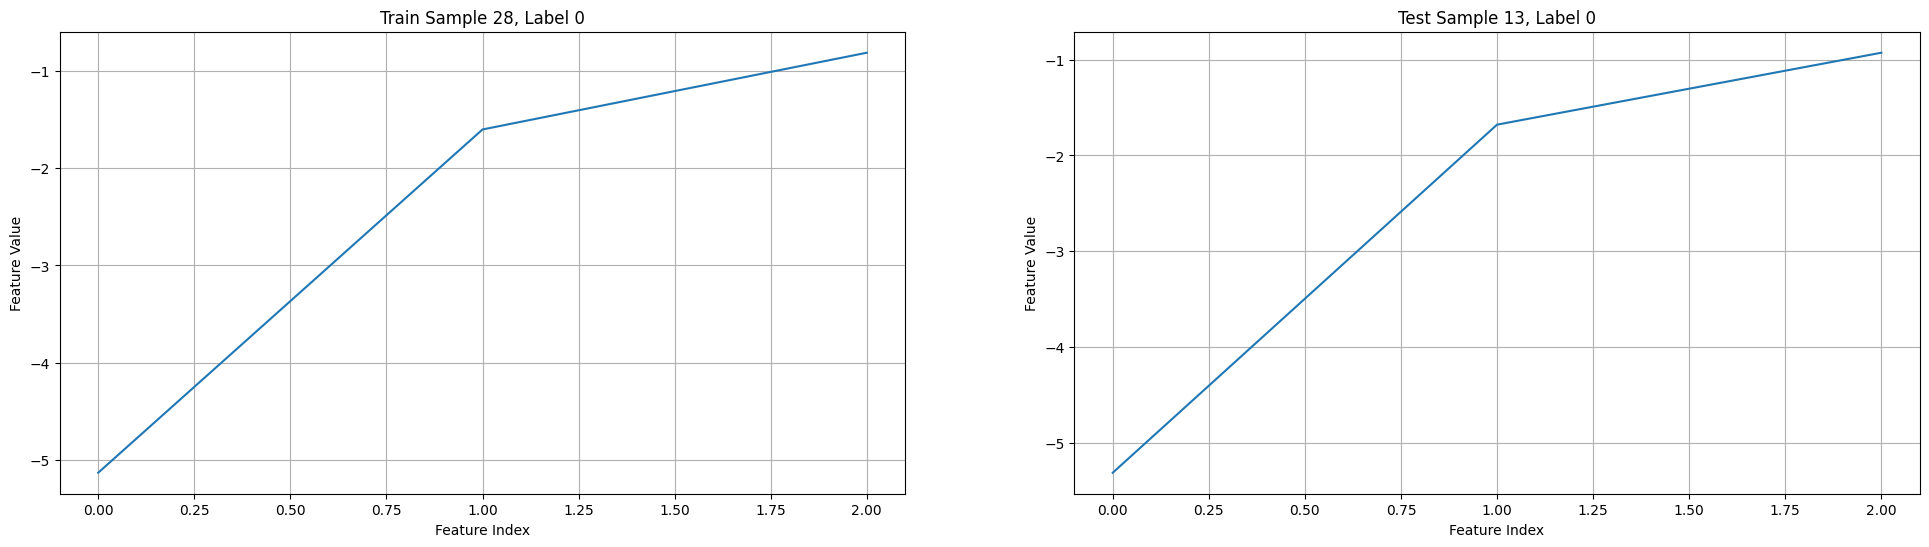

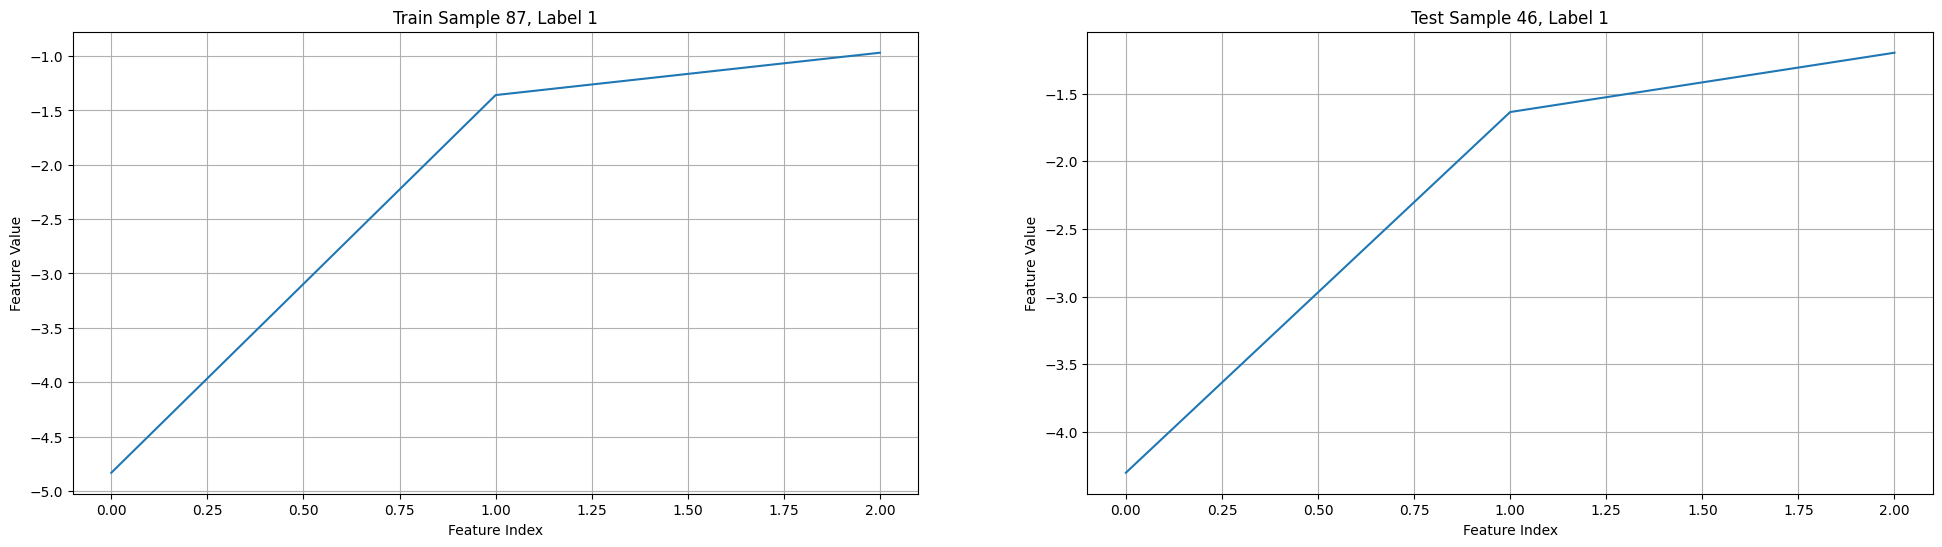

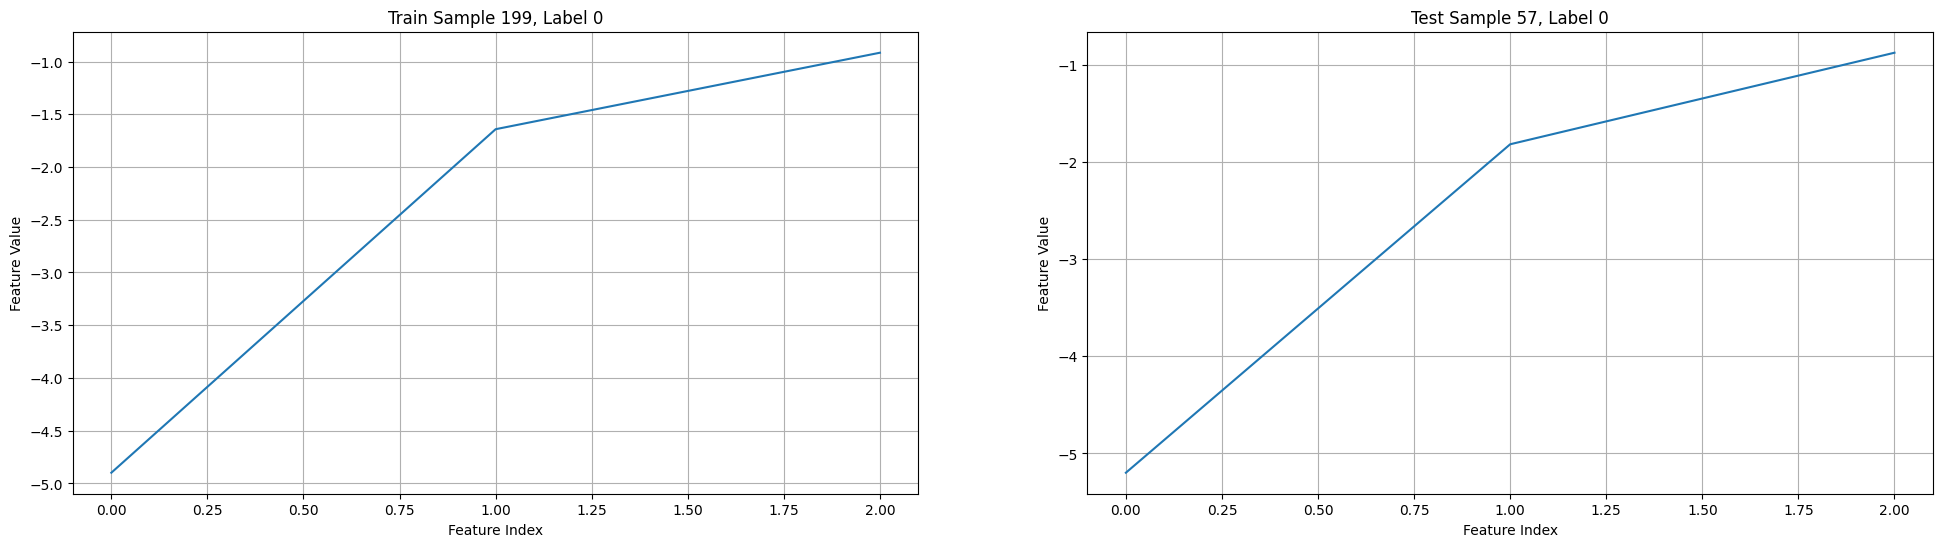

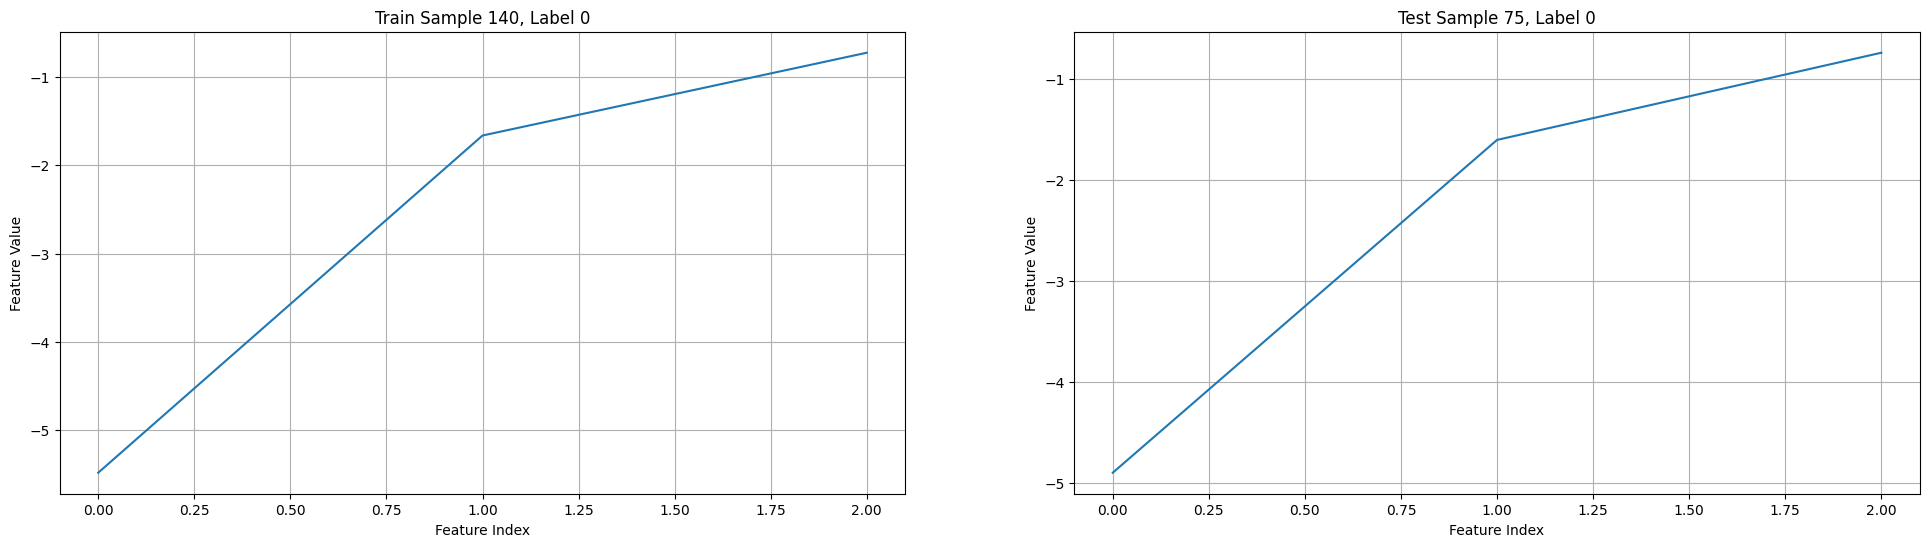

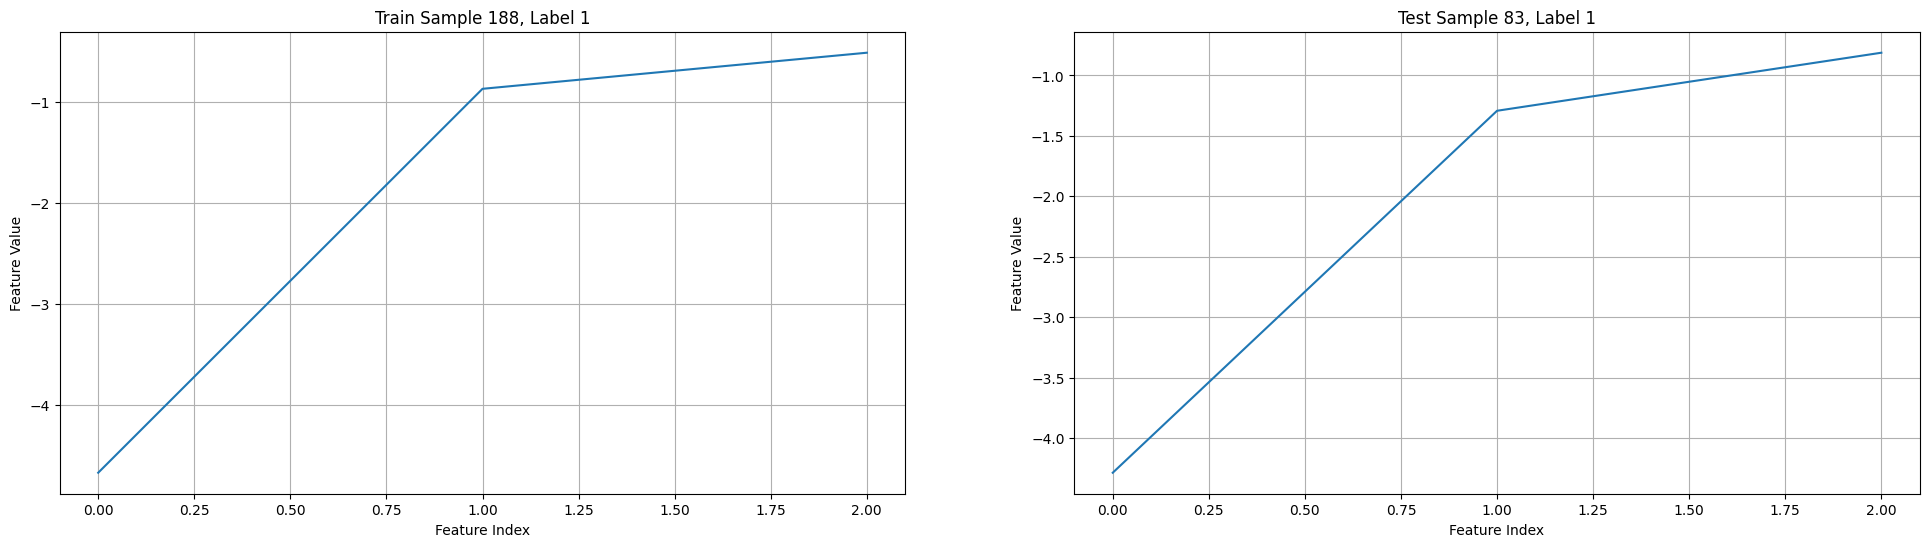

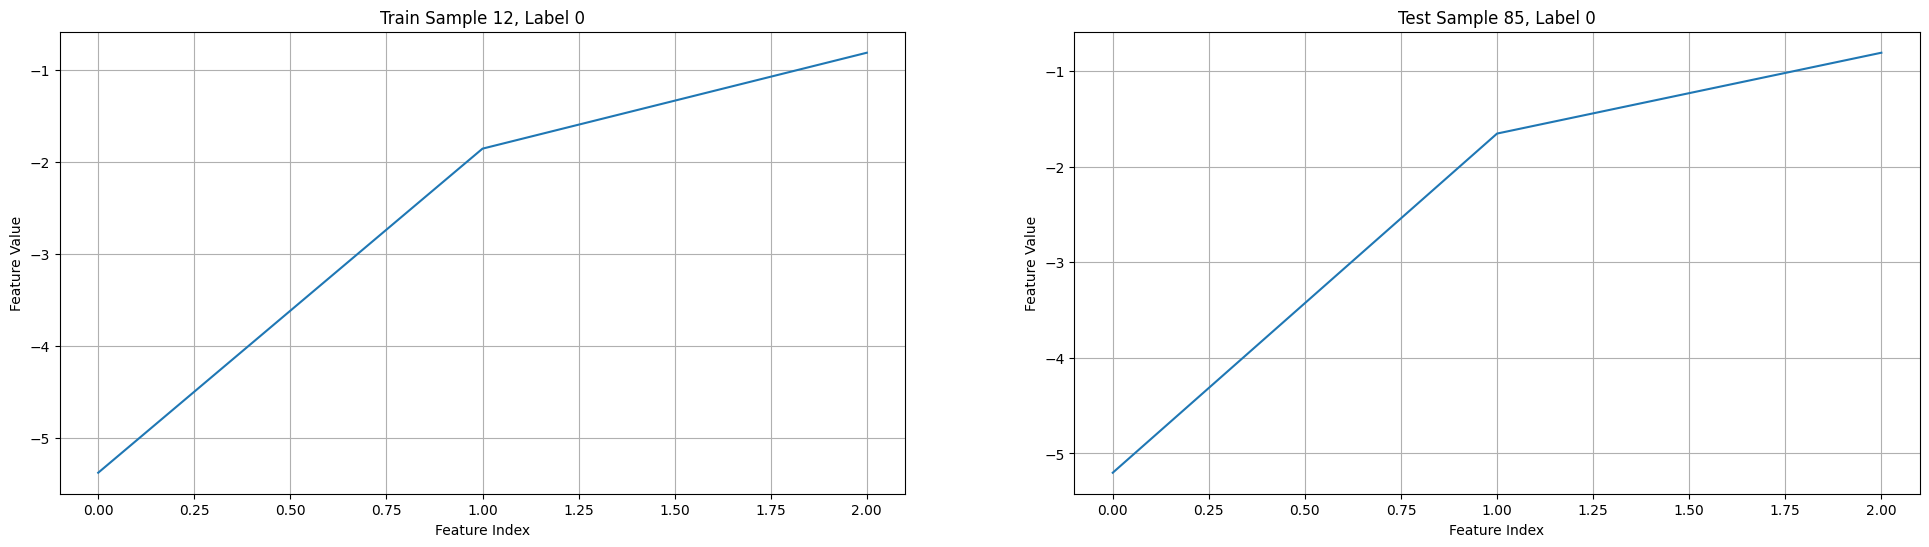

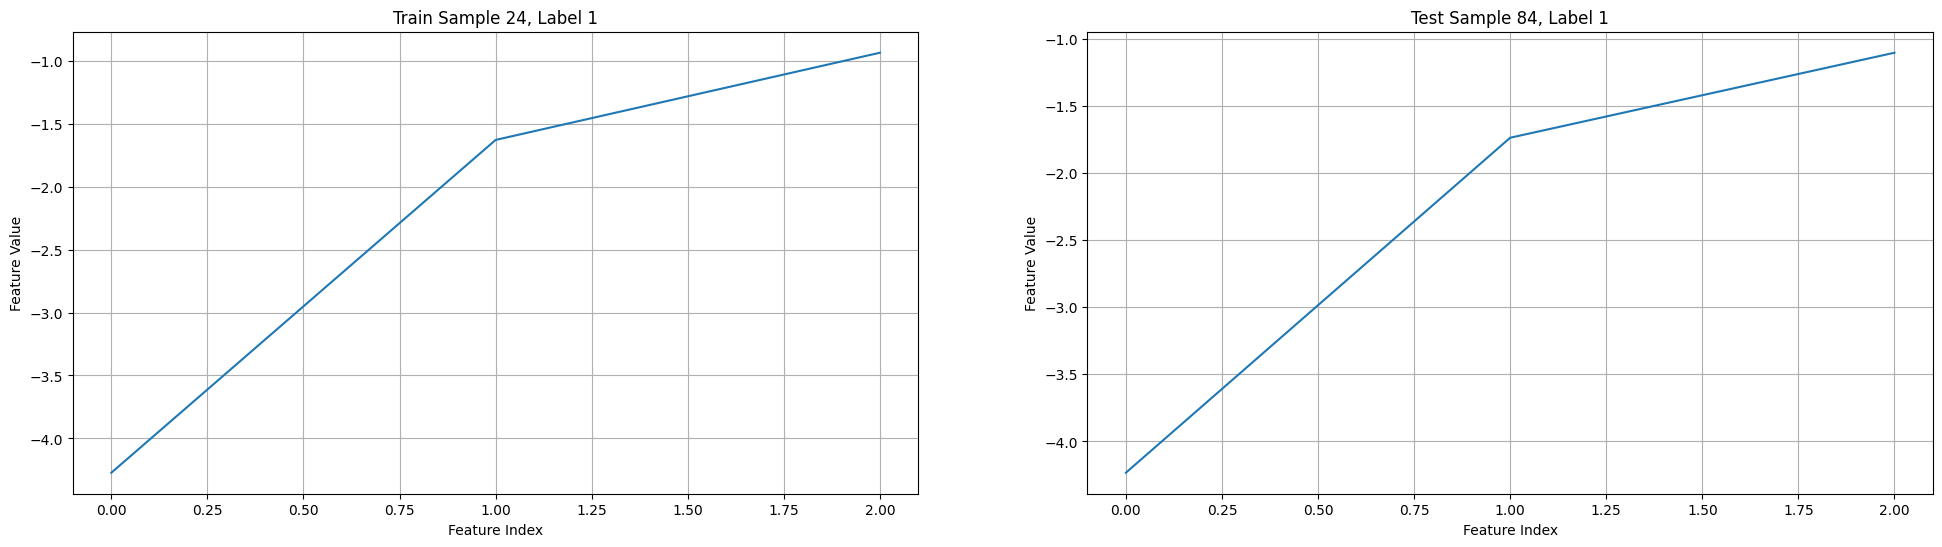

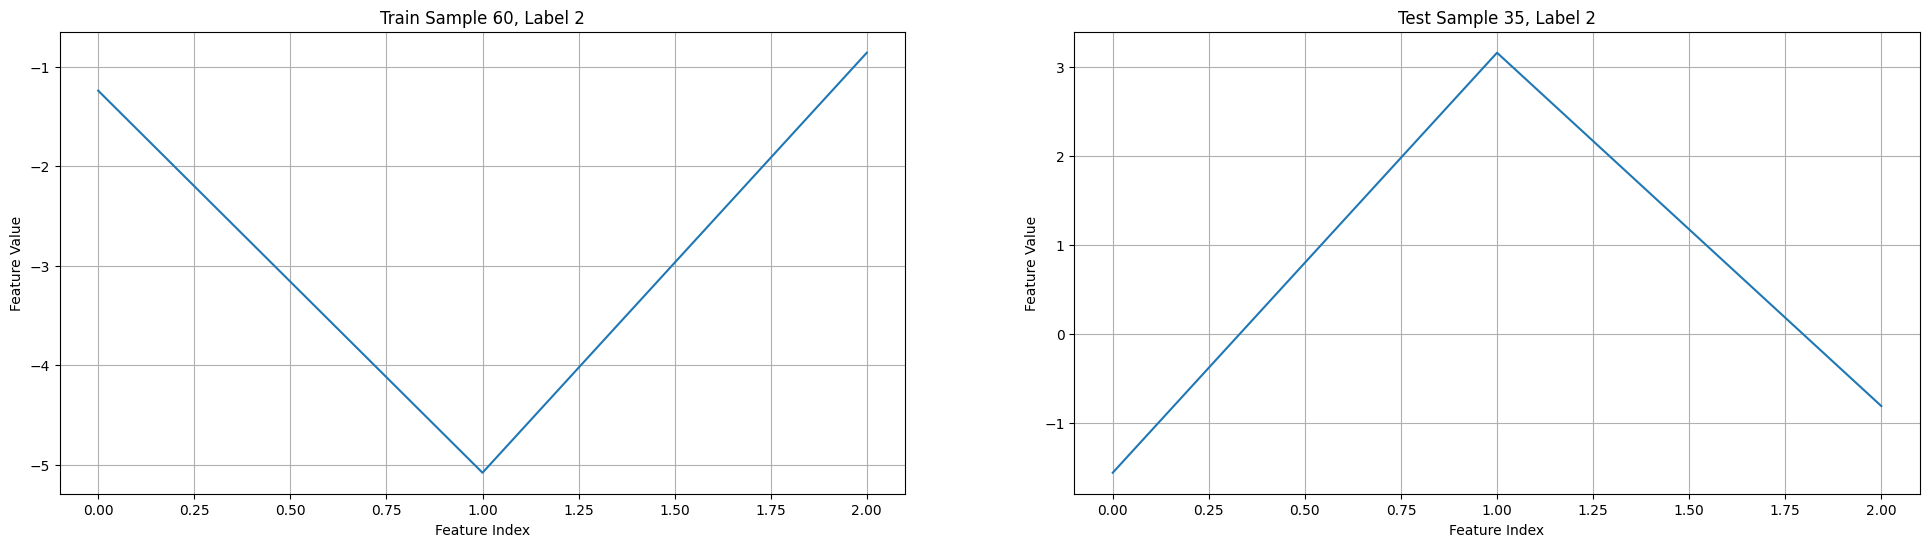

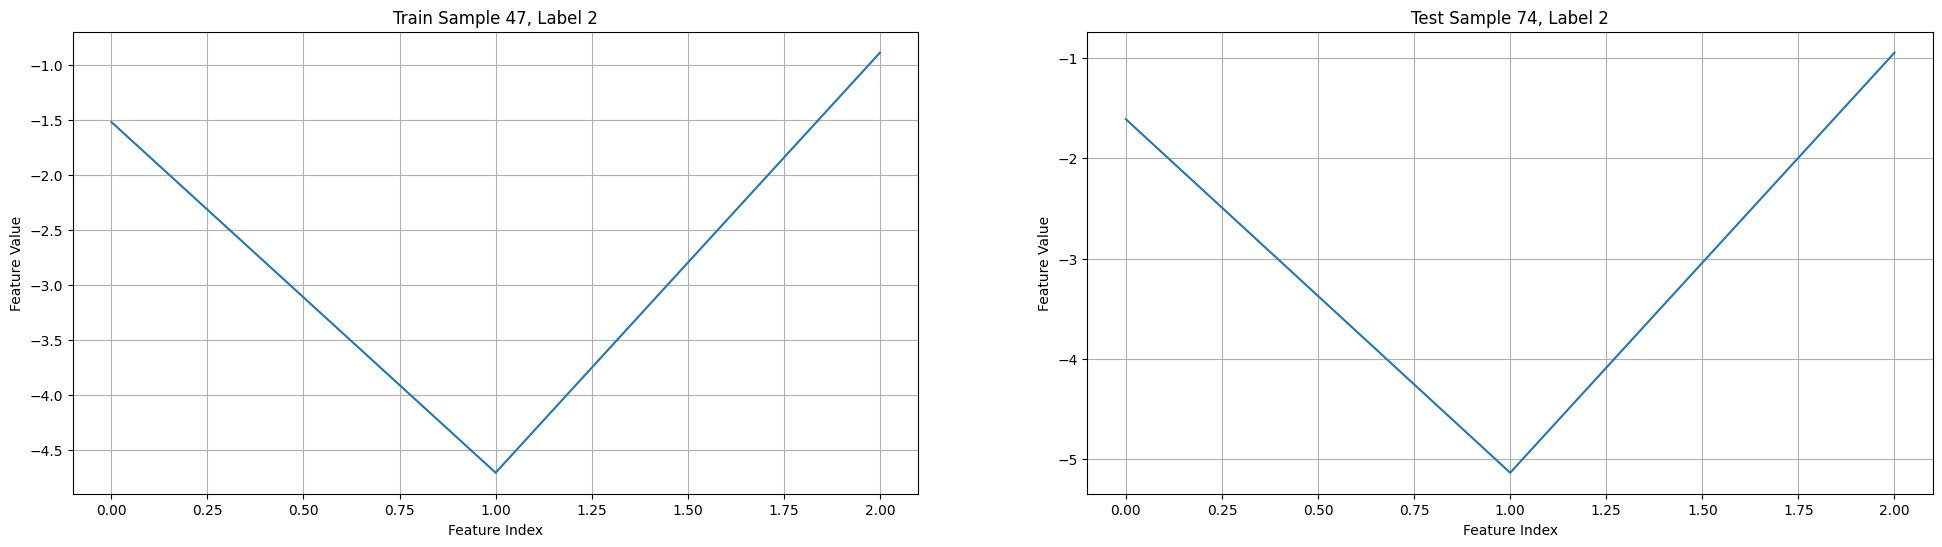

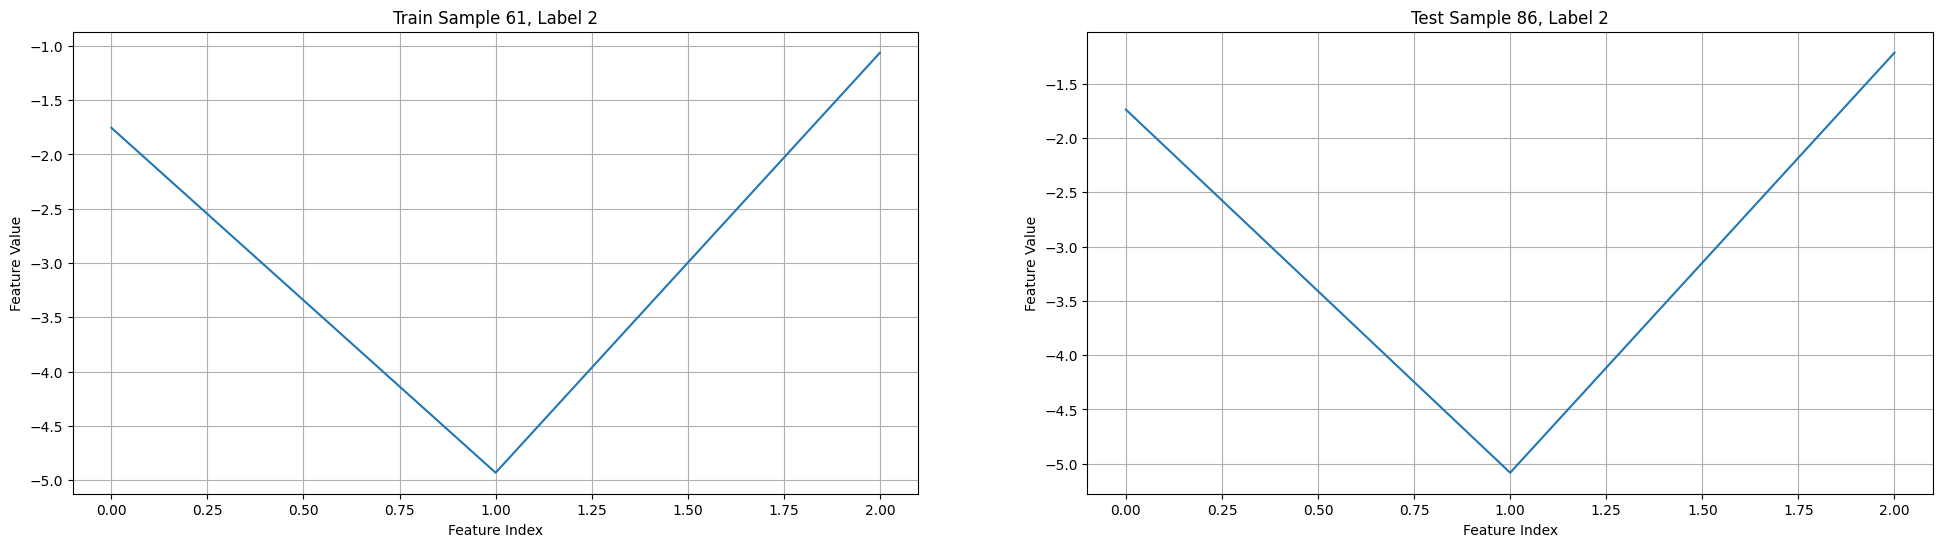

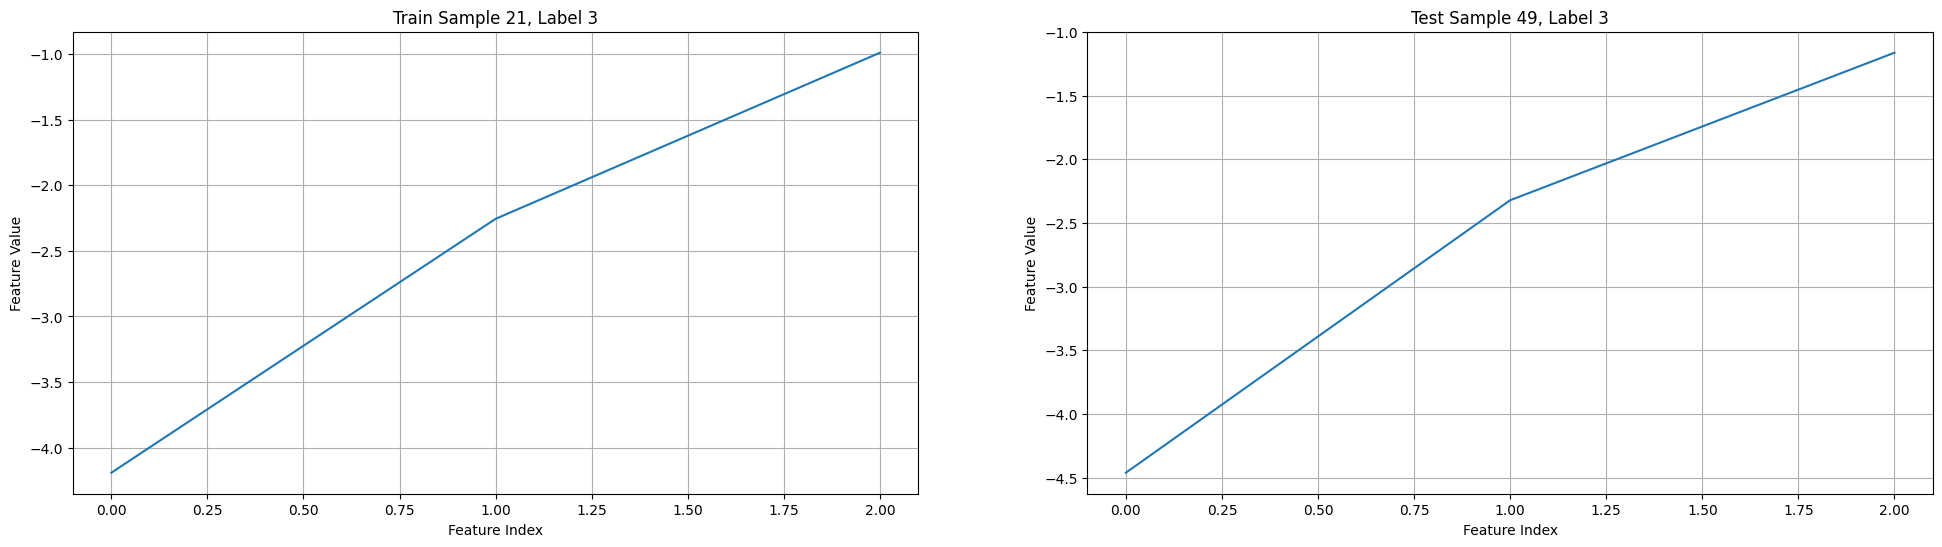

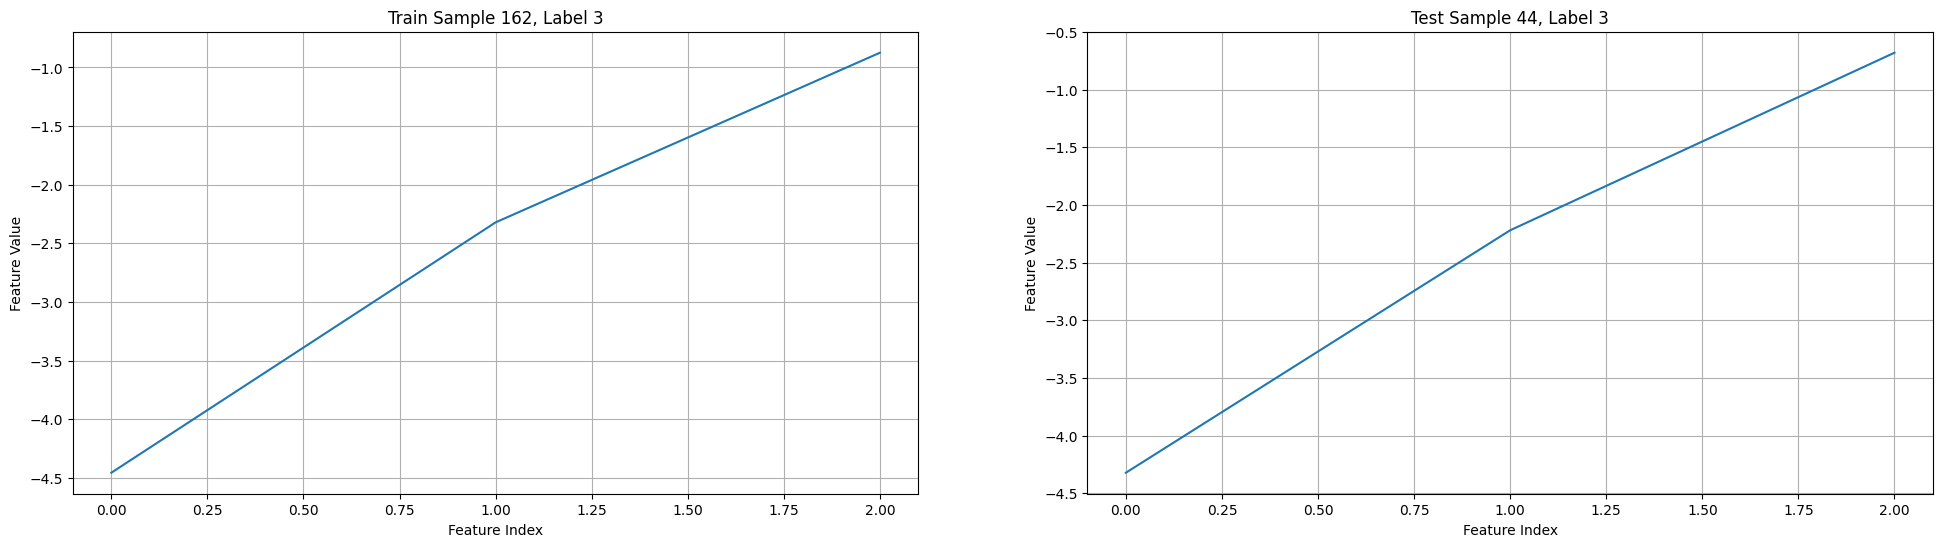

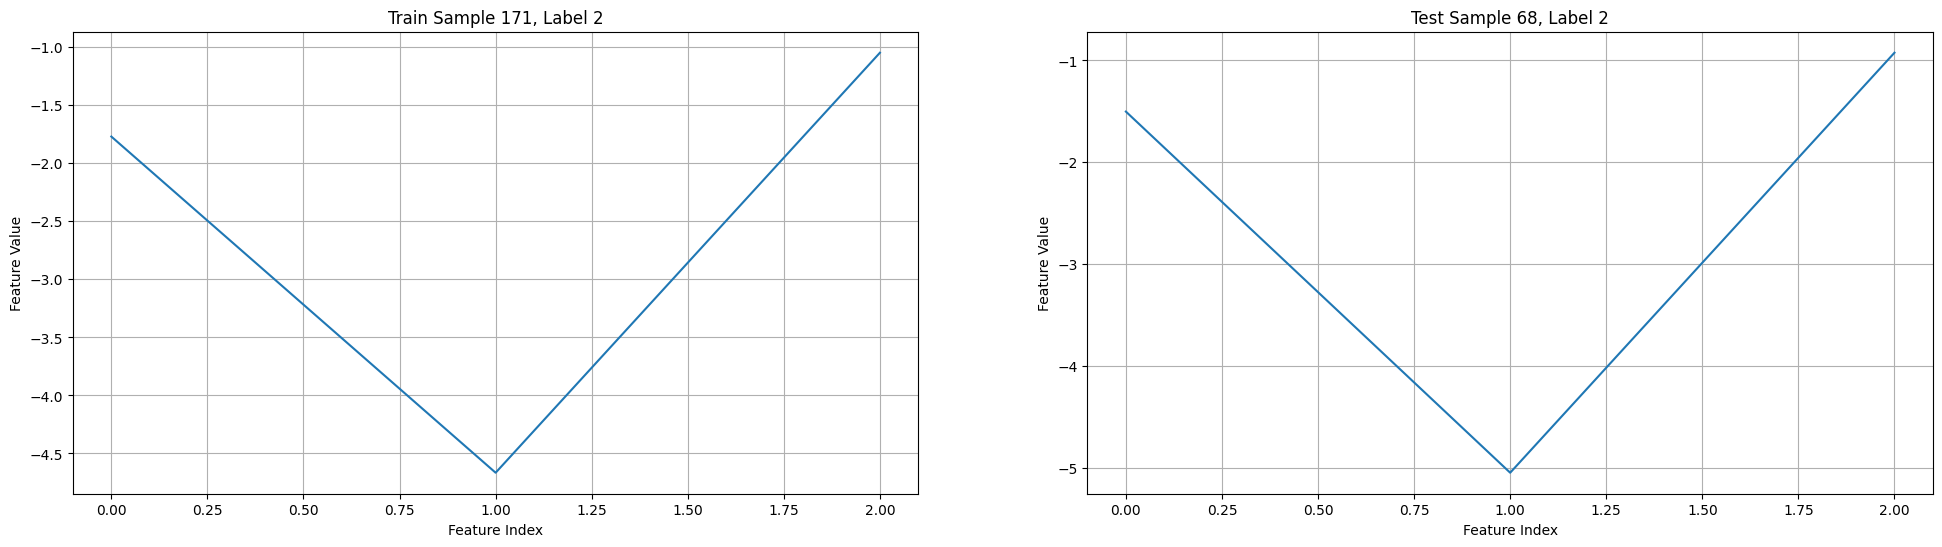

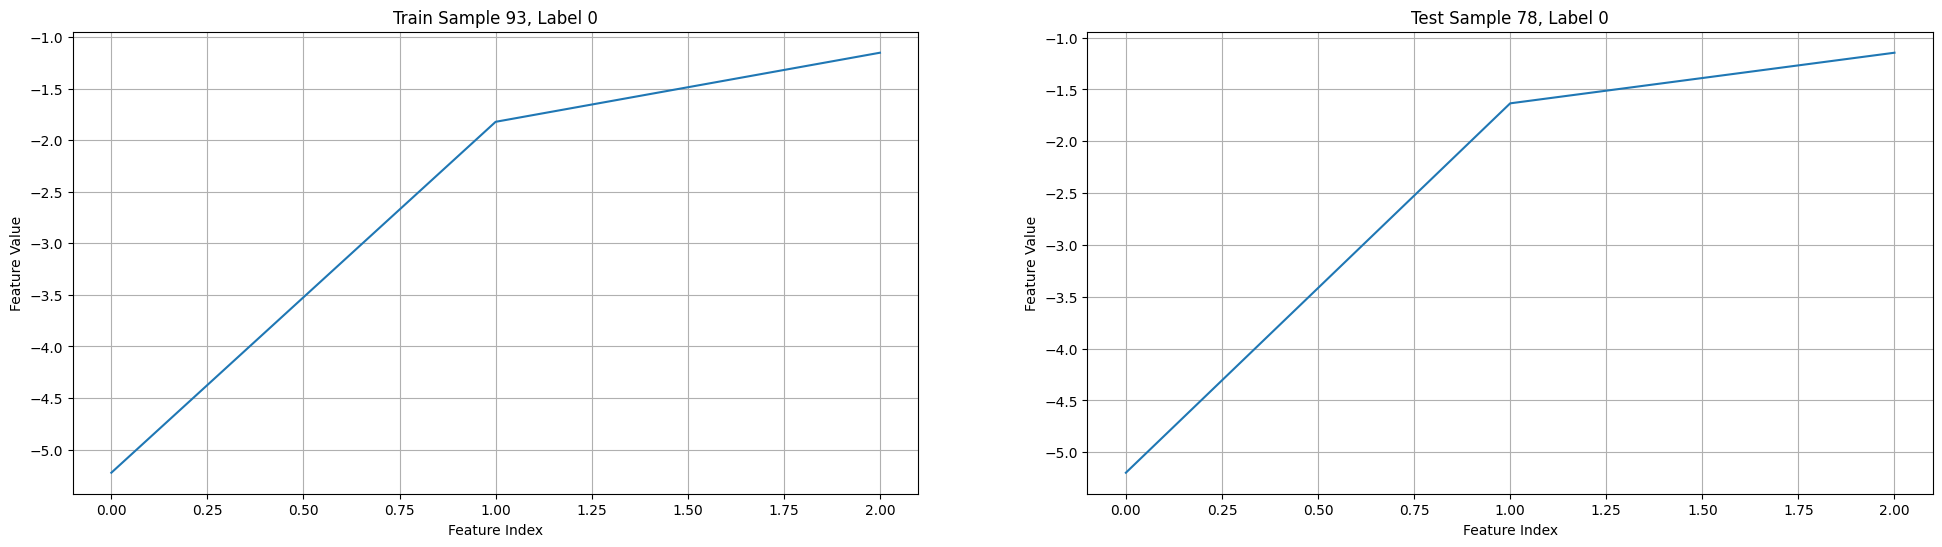

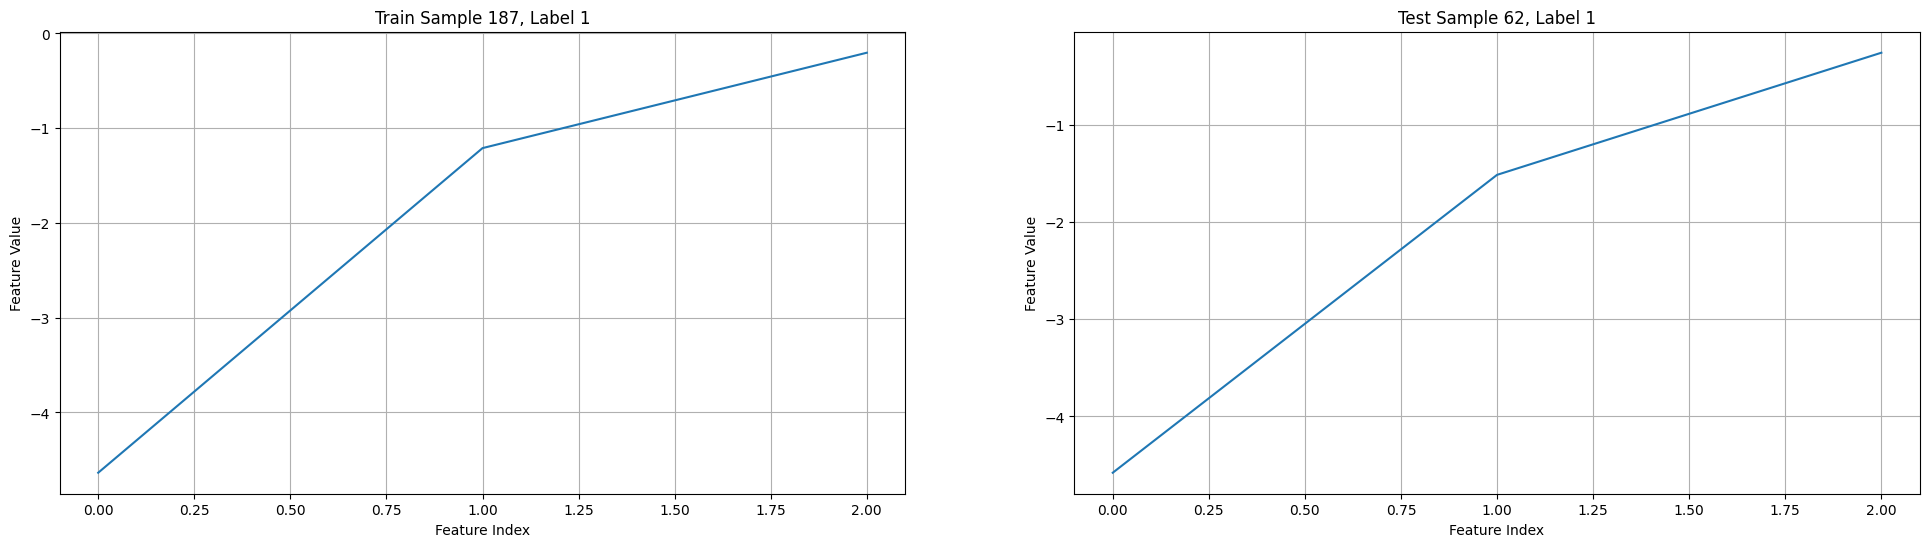

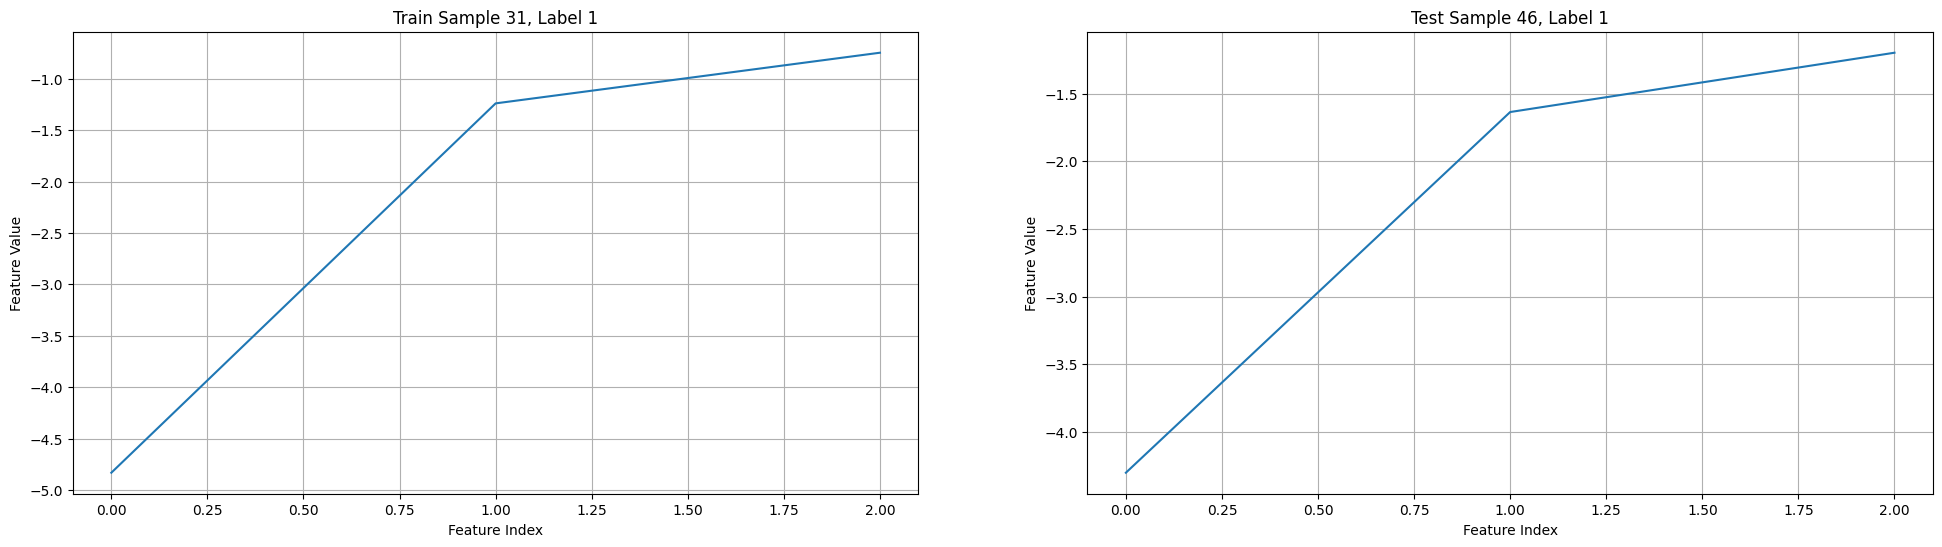

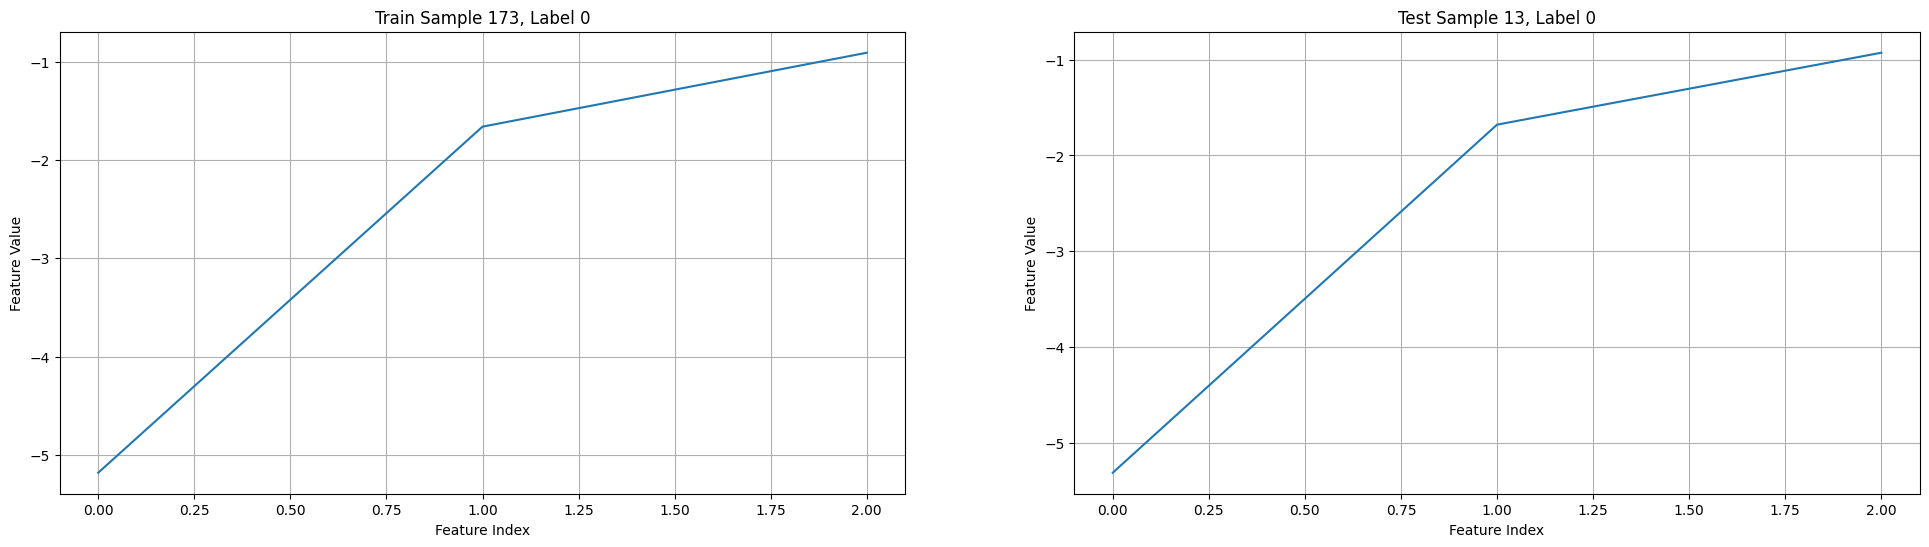

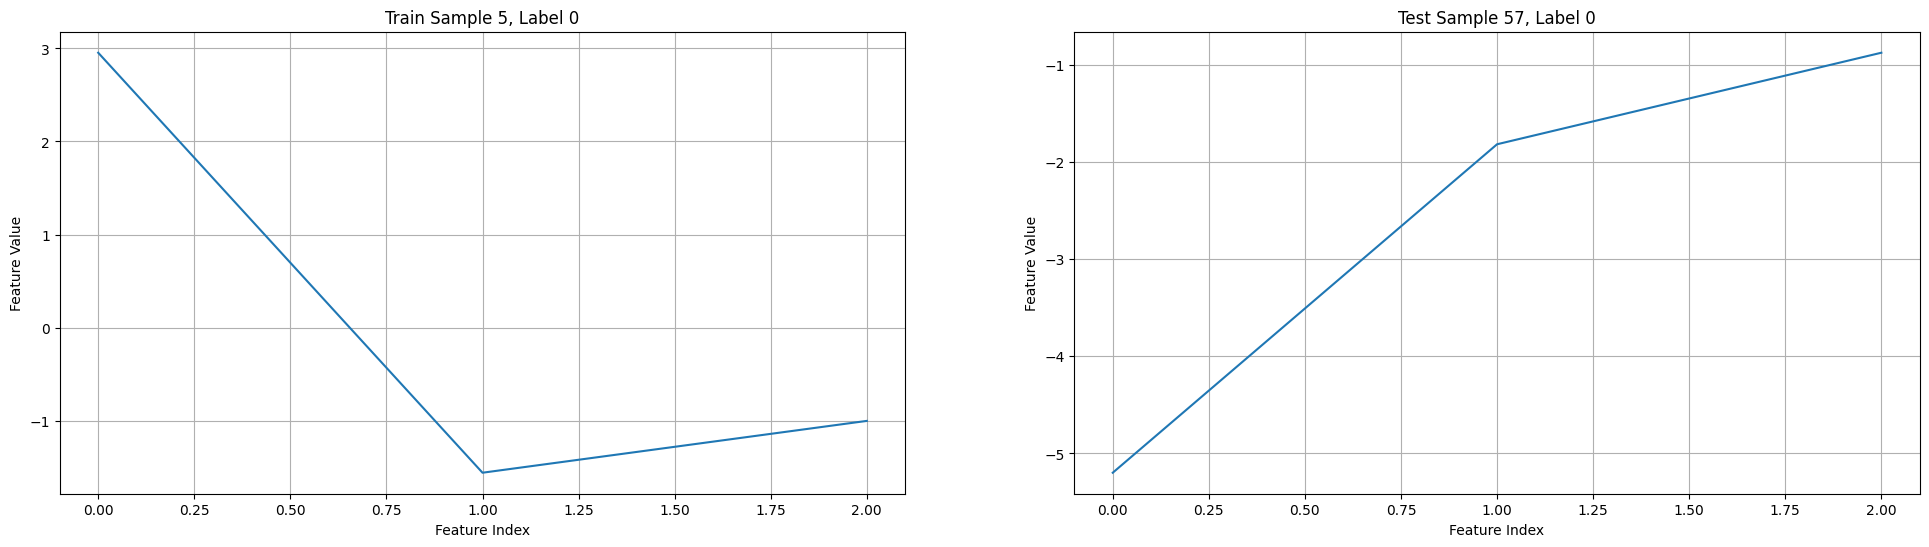

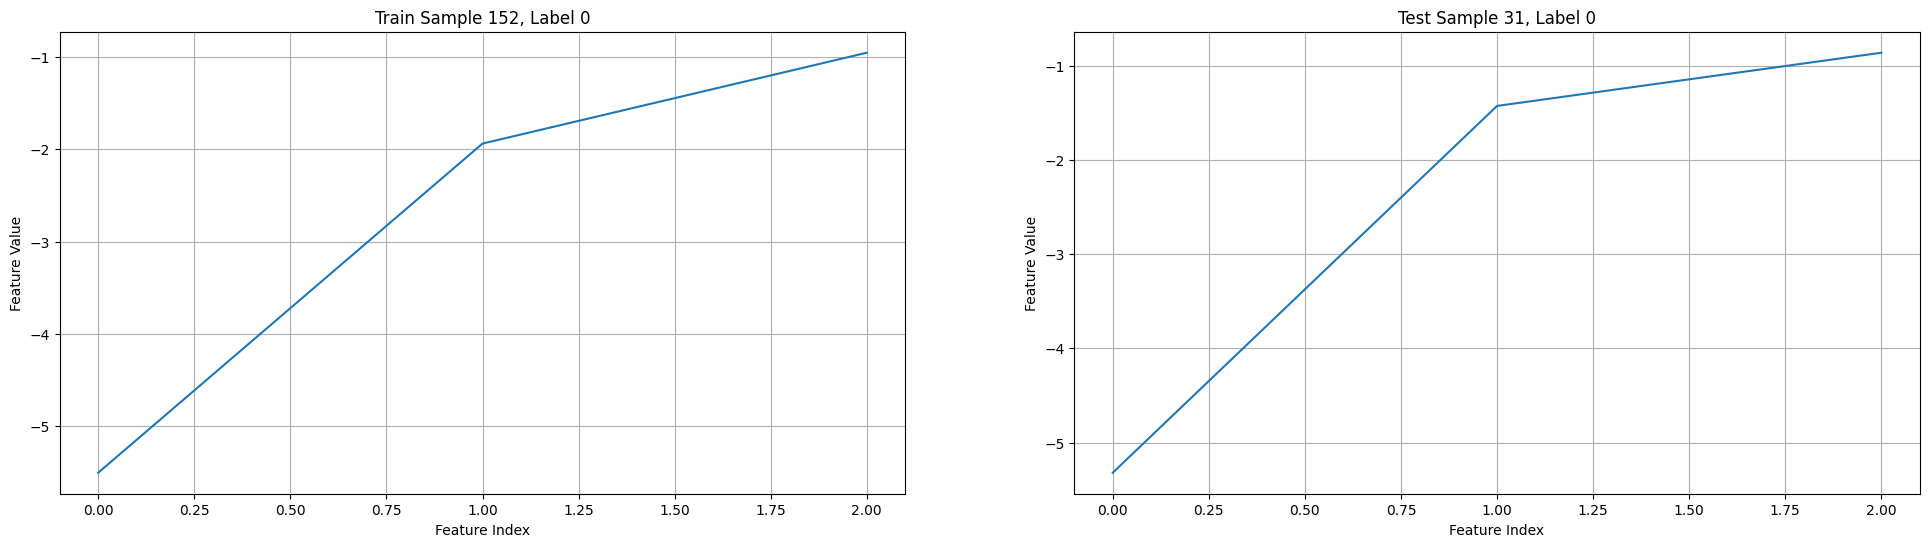

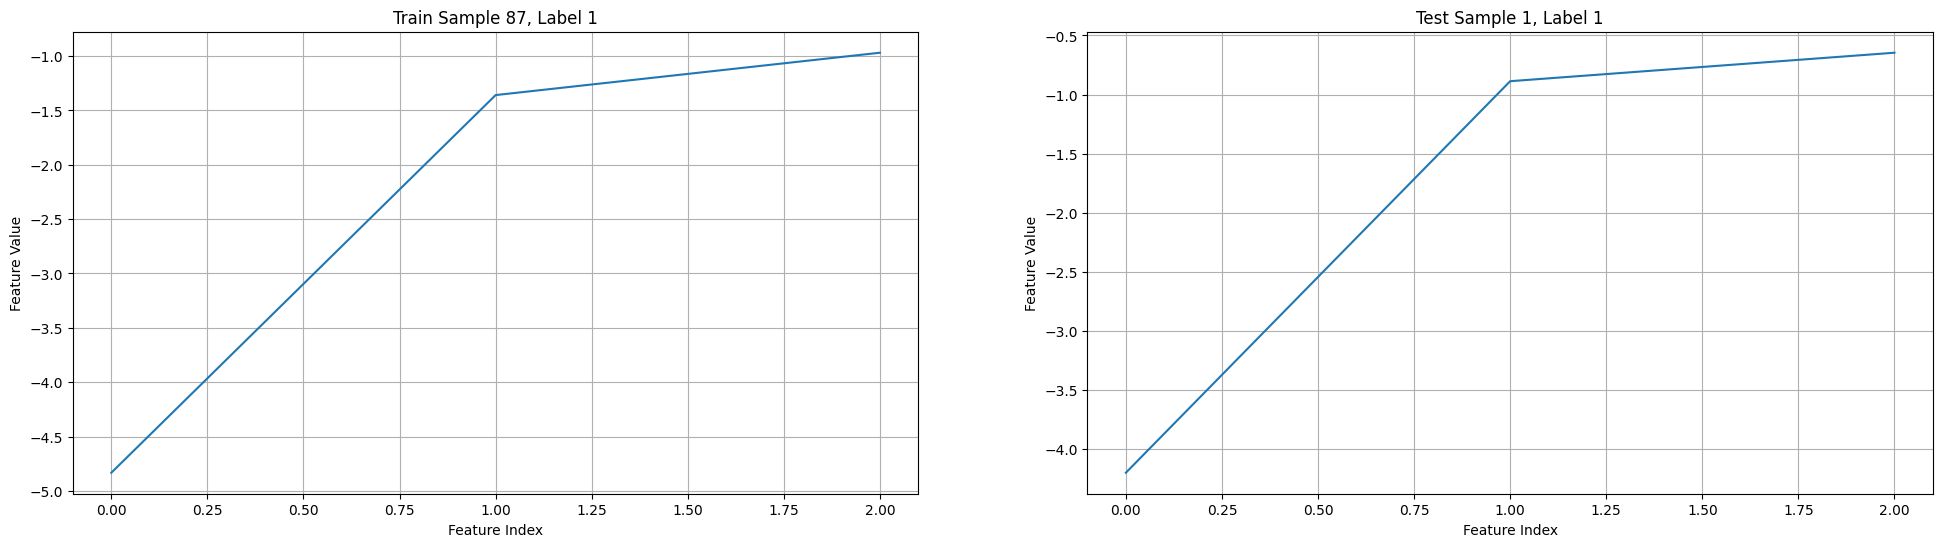

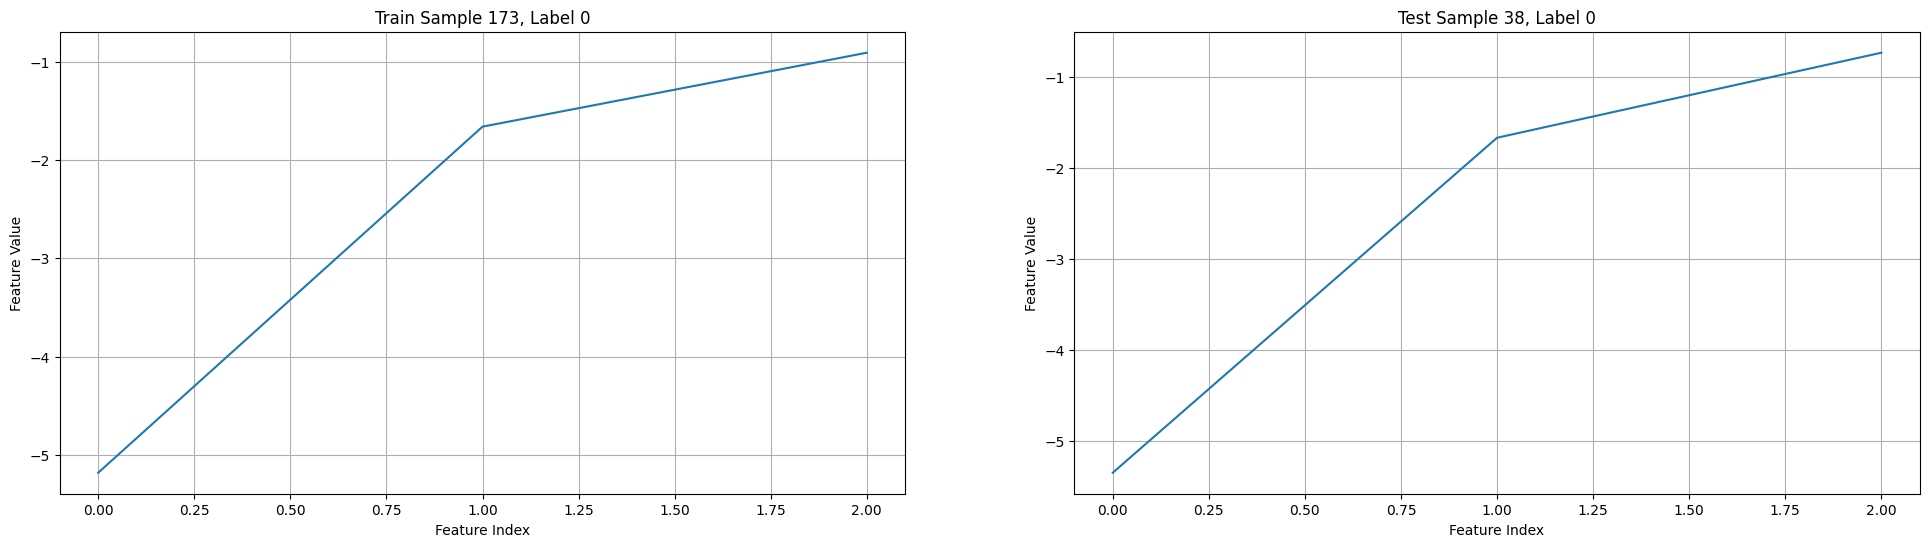

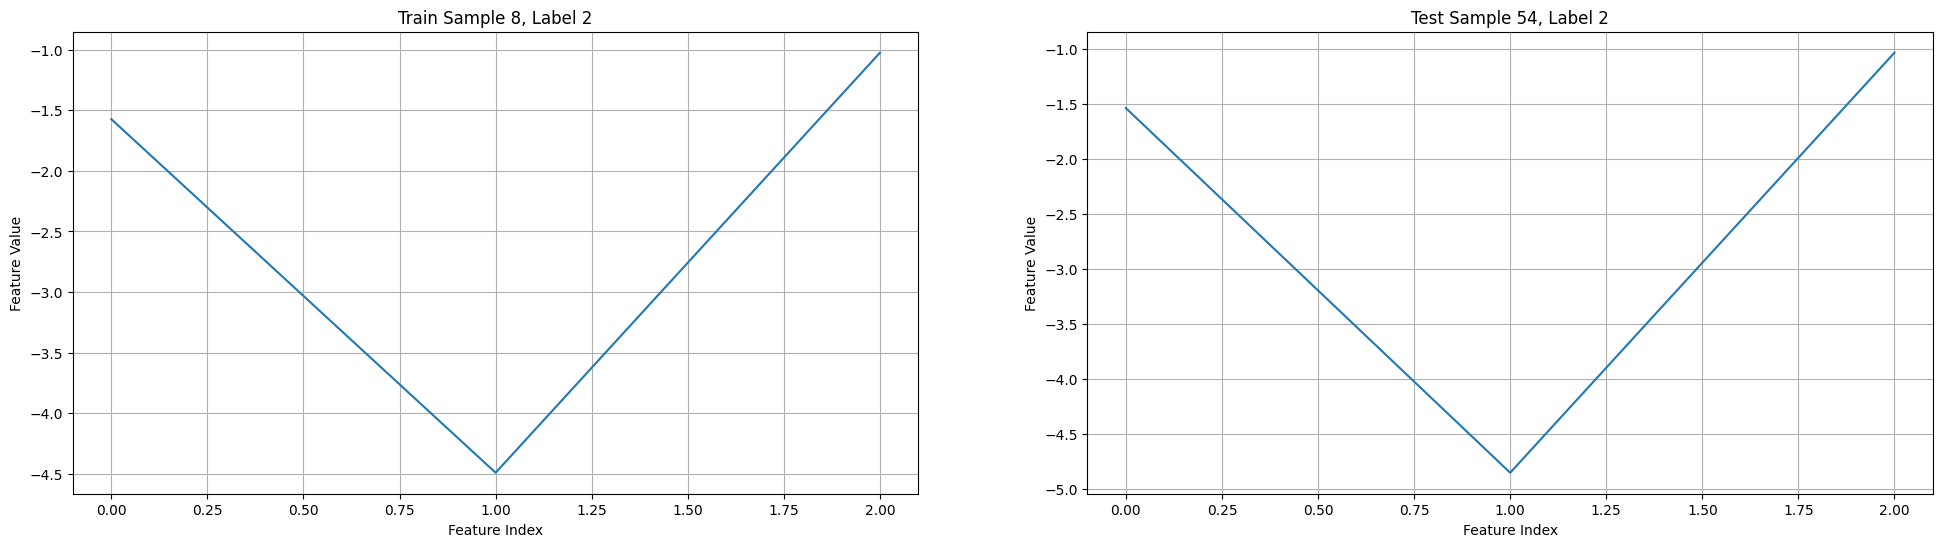

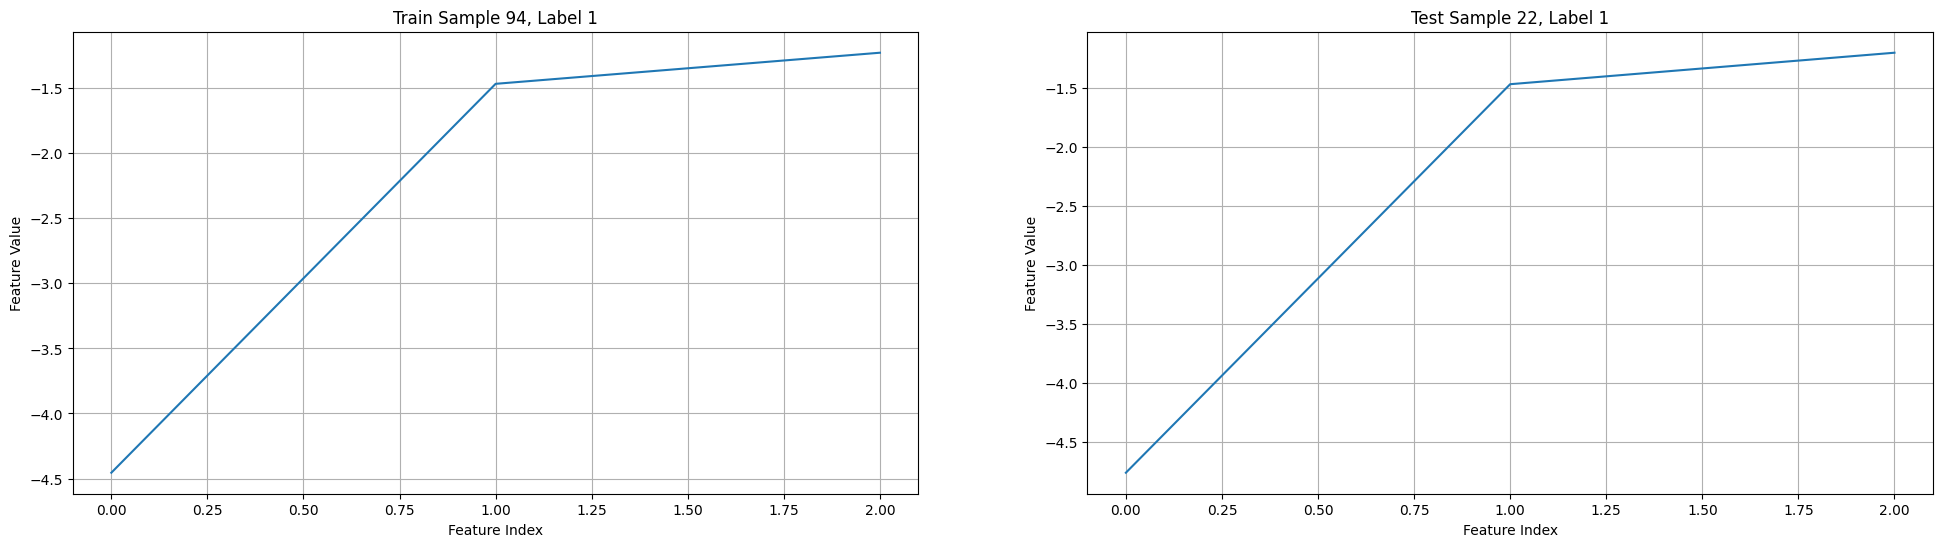

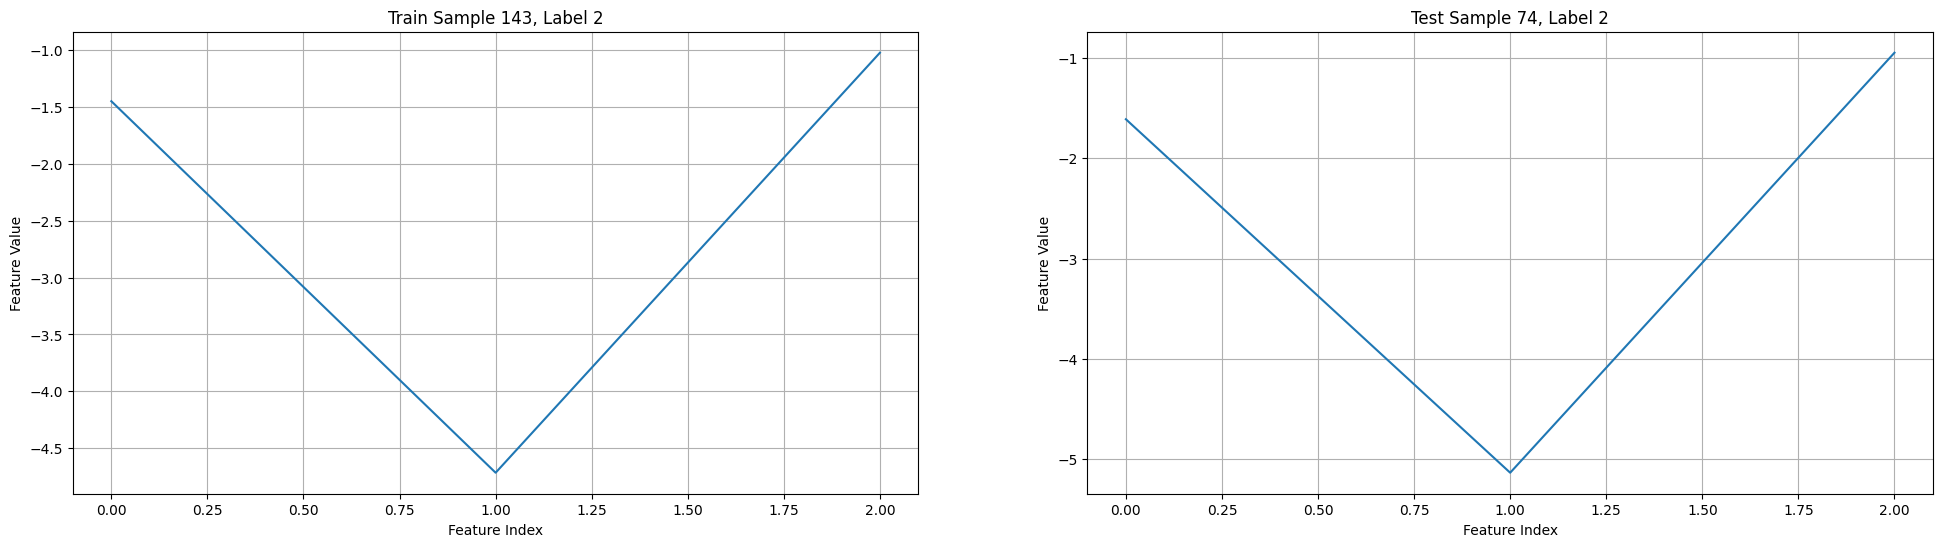

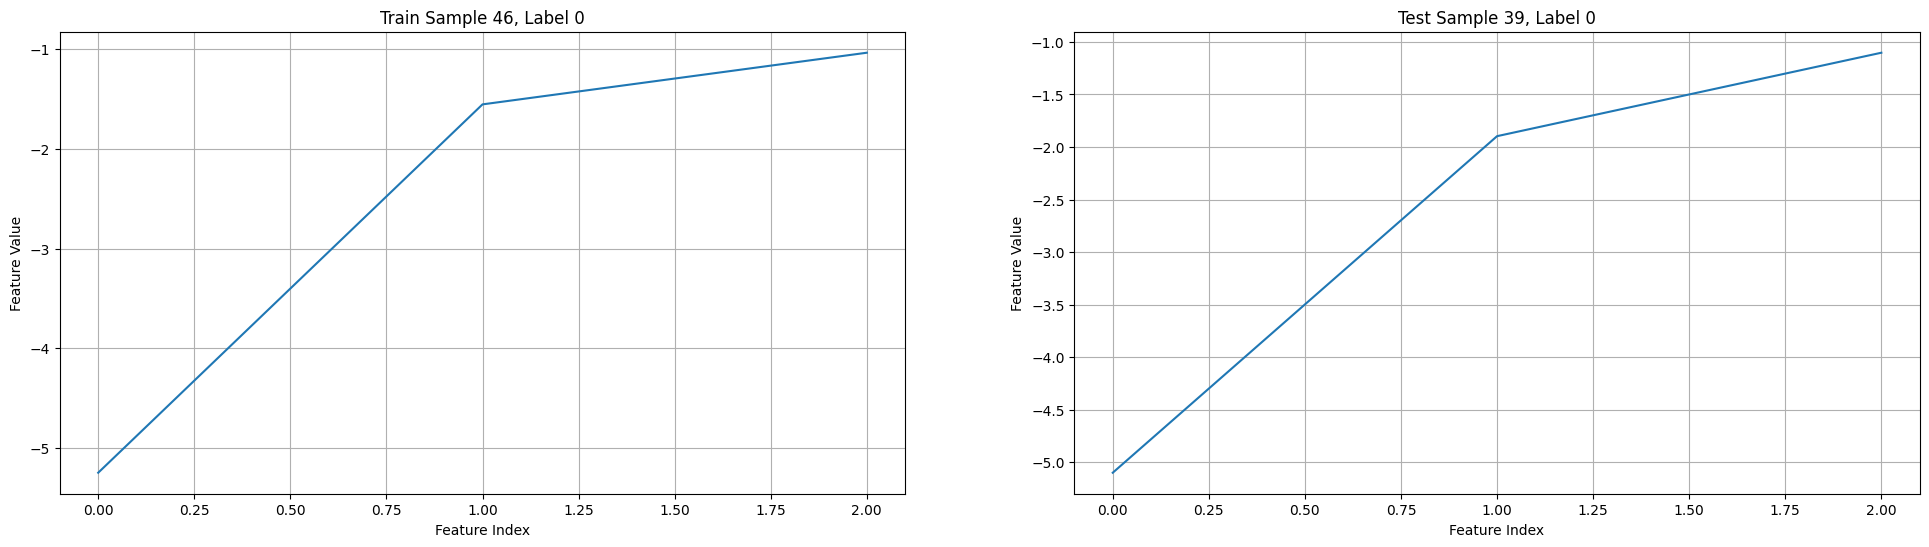

(200, 3)
(87, 3)
(200,)
(87,)
50 50 50 50 3
21 22 22 22 3


In [68]:
import numpy as np
import matplotlib.pyplot as plt
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
for _ in range(25):

  sample_index_train = random.randint(0, len(X_train) - 1)
  train_sample = X_train[sample_index_train]
  train_label = y_train[sample_index_train]

  match_indices = np.where(y_test == train_label)[0]
  sample_index_test = random.choice(match_indices)
  test_sample = X_test[sample_index_test]


  feature_axis = np.arange(len(train_sample))


  plt.figure(figsize=(24, 6))

  # Plot train sample
  plt.subplot(1, 2, 1)
  plt.plot(feature_axis, train_sample)
  plt.title(f"Train Sample {sample_index_train}, Label {y_train[sample_index_train]}")
  plt.xlabel("Feature Index")
  plt.ylabel("Feature Value")
 
  plt.grid(True)

  # Plot test sample
  plt.subplot(1, 2, 2)
  plt.plot(feature_axis, test_sample)
  plt.title(f"Test Sample {sample_index_test}, Label {y_test[sample_index_test]}")
  plt.xlabel("Feature Index")
  plt.ylabel("Feature Value")
 
  plt.grid(True)

  plt.show()


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
lst = y_train.tolist()
print(lst.count(0),lst.count(1),lst.count(2),lst.count(3),GLOBAL_SHAPE_LENGTH)
lst = y_test.tolist()
print(lst.count(0),lst.count(1),lst.count(2),lst.count(3),GLOBAL_SHAPE_LENGTH)

In [69]:
import gym
import numpy as np
import random

class Plasticity(gym.Env):
  #dataset=(X_train, y_train)
    def __init__(self, images_per_episode=1, dataset=(X_train, y_train), random=True):
        super().__init__()

        self.action_space = gym.spaces.Discrete(4)
        self.observation_space = gym.spaces.Box(low=-3, high=3,
                                                shape=(GLOBAL_SHAPE_LENGTH,),
                                                dtype=np.float32)
        self.images_per_episode = images_per_episode
        self.step_count = 0

        self.x, self.y = dataset
        self.random = random
        self.dataset_idx = 0

        # Reward and penalty parameters
        self.initial_reward = 1
        self.final_reward = 15  # Example final reward
        self.reward_increment = 0.1  # Increment for reward

        self.initial_penalty = -1
        self.final_penalty = -15  # Example final penalty
        self.penalty_increment = -1/1500.0  # Increment for penalty

        self.current_reward = self.initial_reward
        self.current_penalty = self.initial_penalty

    def step(self, action):
        done = False
        reward = self.calculate_reward(action)

        obs = self._next_obs()

        self.step_count += 1
        if self.step_count >= self.images_per_episode:
            done = True

        return obs, reward, done, {}

    def reset(self):
        self.step_count = 0

        # Update reward and penalty values
        #self.update_reward_penalty()

        obs = self._next_obs()
        return obs

    def _next_obs(self):
        if self.random:
            next_obs_idx = random.randint(0, len(self.x) - 1)
            self.expected_action = int(self.y[next_obs_idx])
            obs = self.x[next_obs_idx]
        else:
            obs = self.x[self.dataset_idx]
            self.expected_action = int(self.y[self.dataset_idx])

            self.dataset_idx += 1
            if self.dataset_idx >= len(self.x):
                raise StopIteration()

        return obs

    def calculate_reward(self, action):
      if action == self.expected_action:
          reward = 1
      else:
          reward = 0

      return reward

    def update_reward_penalty(self):
        if self.current_penalty > self.final_penalty:
            self.current_penalty += self.penalty_increment
            self.current_penalty = max(self.current_penalty, self.final_penalty)


In [70]:
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Input
from tensorflow.keras.optimizers import Adam
tf.compat.v1.experimental.output_all_intermediates(True)

In [71]:
env = Plasticity()
states = env.observation_space.shape
actions = env.action_space.n
print(env.action_space)
print(states,actions)

Discrete(4)
(3,) 4


In [72]:
from tensorflow.keras.layers import Conv1D, Dropout, AveragePooling1D, SpatialDropout1D, MaxPooling1D, BatchNormalization, LSTM, Flatten, Dense, PReLU, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from keras.regularizers import l1_l2

def build_model(states, actions):
    model = Sequential([
        Flatten(input_shape=(1,)+states),  # Flatten the input to shape (3,)
        Dense(32,activation='relu'),
        #PReLU(),
        Dense(32,activation='relu'),
        #PReLU(),
        Dense(actions, activation='linear')  # 'actions' is the number of output classes
    ])
    return model


In [73]:
import tensorflow as tf
#!pip install keras-rl2
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory
from keras import __version__
import tensorflow as tf

# To reset all information and start fresh, clear the current Keras session:
tf.keras.backend.clear_session()

#with strategy.scope():
model = build_model(states, actions)

model.build(input_shape=(1,*states))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 1316 (5.14 KB)
Trainable params: 1316 (5.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [74]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy(0.3) #LinearAnnealedPolicy(, attr='eps', value_max=1., value_min=0, value_test=.05, nb_steps=6000)
    memory = SequentialMemory(limit=1000000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  nb_actions=actions, nb_steps_warmup=300, target_model_update=1e-2)
    return dqn

In [75]:
#with strategy.scope():
dqn = build_agent(model, actions)
dqn.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00005),metrics=['mse'])

2024-01-30 19:58:49.809943: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_3/bias/Assign' id:98 op device:{requested: '', assigned: ''} def:{{{node dense_3/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_3/bias, dense_3/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [76]:
from rl.callbacks import Callback

#print(dqn.policy.eps)
class LossHistory(Callback):
    def __init__(self):
        self.losses = []

    def on_step_end(self, step, logs={}):
        self.losses.append(logs['metrics'][0])

class LossHistory2(Callback):
    def __init__(self):
        self.losses = []

    def on_step_end(self, step, logs={}):
        self.losses.append(logs['metrics'][1])

class RewardHistory(Callback):
    def on_train_begin(self, logs={}):
        self.rewards = []

    def on_episode_end(self, episode, logs={}):
        self.rewards.append(logs['episode_reward'])

class ExponentialDecayEpsilonCallback(Callback):
    def __init__(self, initial_epsilon, min_epsilon, decay_rate, decay_steps):
        self.epsilon = initial_epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.step_count = 0

    def on_step_end(self, step, logs={}):
        self.step_count += 1
        # if(self.epsilon <= 1e-10):
        #     self.epsilon=0.5
        self.epsilon = self.min_epsilon + (self.epsilon - self.min_epsilon) * np.exp(-self.step_count / self.decay_steps)
        self.model.policy.eps = max(self.epsilon, self.min_epsilon)
        
        if(self.step_count % 400 == 0): print(f" Epsilon: {self.epsilon}")

# Example usage
initial_epsilon = 1.0  # Starting value of epsilon
min_epsilon = 0.0  # Minimum value epsilon can reach

decay_rate = 0.0001     # Rate of decay
decay_steps = 15000/(decay_rate*10)    # Number of steps over which epsilon decays
print(decay_rate,decay_steps)
epsilon_decay_cb = ExponentialDecayEpsilonCallback(initial_epsilon, min_epsilon, decay_rate, decay_steps)


loss_history = LossHistory()
loss_history2 = LossHistory2()
reward_history = RewardHistory()


#dqn.load_weights(prefix+'bciiv2a_dqn_weights.hdf5')
dqn.fit(env, nb_steps=30000, log_interval=30000, callbacks=[loss_history,loss_history2,reward_history], verbose=1)

0.0001 15000000.0
Training for 30000 steps ...
Interval 1 (0 steps performed)
    1/30000 [..............................] - ETA: 12:56 - reward: 0.0000e+00

   65/30000 [..............................] - ETA: 23s - reward: 0.3231      

/home/eeshan/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-30 19:58:49.922860: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_2/BiasAdd' id:77 op device:{requested: '', assigned: ''} def:{{{node dense_2/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_2/MatMul, dense_2/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-30 19:58:49.931512: W tensorflow/c/c_api.cc:304] Operation '{name:'count_3/Assign' id:315 op device:{requested: '', assigned: ''} def:{{{node count_3/Assign}} = AssignVariableOp[_has_manual_control_depe

  250/30000 [..............................] - ETA: 24s - reward: 0.2800

2024-01-30 19:58:50.191523: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_2_1/BiasAdd' id:151 op device:{requested: '', assigned: ''} def:{{{node dense_2_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_2_1/MatMul, dense_2_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-30 19:58:50.280641: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_3/AddN' id:410 op device:{requested: '', assigned: ''} def:{{{node loss_3/AddN}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss_3/mul, loss_3/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-01-30 19:58:5

30000/30000 [==============================] - 176s 6ms/step - reward: 0.7330
done, took 175.887 seconds


In [77]:
dqn.policy.eps = 0
dqn.fit(env, nb_steps=400, callbacks=[loss_history,loss_history2,reward_history], verbose=1)
dqn.fit(env, nb_steps=400, callbacks=[loss_history,loss_history2,reward_history], verbose=1)

Training for 400 steps ...
Interval 1 (0 steps performed)
  398/10000 [>.............................] - ETA: 20s - reward: 0.8467done, took 0.867 seconds
Training for 400 steps ...
Interval 1 (0 steps performed)
  397/10000 [>.............................] - ETA: 20s - reward: 0.8463done, took 0.860 seconds


In [78]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold


def dqn_eval(dqn_agent,d):
    attempts, correct = 0, 0
    labels = d[1]
    eenv = Plasticity(dataset=d, random=False)
    thing = 1
    y_predFull = []
    y_trueest = []
    total_reward = 0



    try:

        while True:

            if thing == 1:
                obs = eenv.reset()
                thing = 0
            done = False
            while not done:

                obs_reshaped = np.reshape(obs, (1,) + obs.shape)

                q_values = dqn_agent.compute_q_values(obs_reshaped)
                #print(q_values)

                action = np.argmax(q_values)

                #print('action: ', action, " - ", labels[attempts])
                y_predFull.append(action)
                y_trueest.append(labels[attempts])

                obs, rew, done, _ = eenv.step(action)
                total_reward += rew
                if done:
                    attempts += 1

    except StopIteration:
        print()
        print('Validation done...','total reward=',total_reward)

        y_predFull = np.array(y_predFull)
        y_trueest = np.array(y_trueest)

        cm = confusion_matrix(y_trueest, y_predFull)
        print(y_predFull)
        print(y_trueest)

        print("Confusion Matrix:\n", cm)

        report = classification_report(y_trueest, y_predFull,digits=4)
        print("Classification Report:\n", report)

        report = classification_report(y_trueest, y_predFull,output_dict=True)

        correct = sum(y_predFull == y_trueest)
        attempts = len(y_trueest)
        accuracy = (float(correct) / attempts)
        print('Validation done...')
        print('Accuracy: {:.2f}%'.format(accuracy*100))

        F1 = report['macro avg']['f1-score']
        precision = report['macro avg']['precision']
        recall = report['macro avg']['recall']

        print("F1 Score: {:.2f}%".format(F1*100))
        print("Precision: {:.2f}%".format(precision*100))
        print("Recall: {:.2f}%".format(recall*100))

    y_predFull = []
    y_trueest = []
    return accuracy, F1, precision, recall, total_reward

dqn_eval(dqn,d=(X_train,y_train))
print('***************************************************************************************')
dqn_eval(dqn,d=(X_test,y_test))
print('***************************************************************************************')
import math
def dqn_eval2(thing,dataset):

    n_splits = 5

    mean_rewards_per_fold = []
    acc_per_fold = []
    f1_mean, p_mean, r_mean = [], [], []


    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    # if flag:
    #   train = X_train
    #   test = y_train
    # else:
    #   train = X_test
    #   test = y_test
    train, test = dataset
    ctr = 11
    for train_index, test_index in skf.split(train,test):
        xtr, xte = train[train_index],train[test_index]
        ytr, yte = test[train_index], test[test_index]

        # if(thing):
        #   #train = np.concatenate((X_train[:round(len(X_train)*0.5*ctr)],xtr))
        #   #test = np.concatenate((y_train[:round(len(y_train)*0.5*ctr)],ytr))
        #   train_env = Plasticity(dataset=(xtr,ytr),random=True)
        #   #dqn.policy.eps=0.00000001
        #   with tf.device(device_name):
        #     dqn.fit(train_env,nb_steps=500,verbose=1)
        # else: dqn.policy.eps=0.0
        acc, f1, p, r, total_reward = dqn_eval(dqn,d=(xte, yte))

        mean_rewards_per_fold.append(total_reward)
        acc_per_fold.append(acc)
        f1_mean.append(f1)
        r_mean.append(r)
        p_mean.append(p)
        ctr -= 2

    overall_mean_reward = np.mean(mean_rewards_per_fold)

    f1_avg, p_avg, r_avg = np.mean(f1_mean), np.mean(p_mean), np.mean(r_mean)
    print(f"Overall Mean Reward across all folds: {overall_mean_reward}")
    acc_avg = np.mean(acc_per_fold)
    print(f"Overall Mean Accuracy across all folds: {acc_avg * 100} %")
    print(f"Overall Mean F1 across all folds: {f1_avg * 100} %")
    print(f"Overall Mean Precision across all folds: {p_avg * 100} %")
    print(f"Overall Mean Recall across all folds: {r_avg * 100} %")

def dqn_eval3(dqn_agent, dataset):

    n_splits = 10

    mean_rewards_per_fold = []
    acc_per_fold = []
    f1_mean, p_mean, r_mean = [], [], []
    
    train,test=dataset

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for train_index, test_index in skf.split(train,test):
        xtr, xte = train[train_index],train[test_index]
        ytr, yte = test[train_index], test[test_index]

        
        acc, f1, p, r, total_reward = dqn_eval(dqn_agent,d=(xte, yte))

        mean_rewards_per_fold.append(total_reward)
        acc_per_fold.append(acc)
        f1_mean.append(f1)
        r_mean.append(r)
        p_mean.append(p)
        

    overall_mean_reward = np.mean(mean_rewards_per_fold)

    f1_avg, p_avg, r_avg = np.mean(f1_mean), np.mean(p_mean), np.mean(r_mean)
    print(f"Overall Mean Reward across all folds: {overall_mean_reward}")
    acc_avg = np.mean(acc_per_fold)
    print(f"Overall Mean Accuracy across all folds: {acc_avg * 100} %")
    print(f"Overall Mean F1 across all folds: {f1_avg * 100} %")
    print(f"Overall Mean Precision across all folds: {p_avg * 100} %")
    print(f"Overall Mean Recall across all folds: {r_avg * 100} %")

#dqn_eval2(thing=True, dataset=(X_train,y_train))
dqn_eval2(thing=True, dataset=(X_test,y_test))
# final_acc, final_f1, final_p, final_r, final_total_reward = dqn_eval(dqn, d=(X_test, y_test))

# def print_results(acc_per_fold, f1_mean, p_mean, r_mean, final_acc, final_f1, final_p, final_r):
#     acc_avg = np.mean(acc_per_fold)
#     f1_avg, p_avg, r_avg = np.mean(f1_mean), np.mean(p_mean), np.mean(r_mean)

#     print(f"Mean Accuracy across validation sets: {acc_avg * 100} %")
#     print(f"Mean F1 across validation sets: {f1_avg * 100} %")
#     print(f"Mean Precision across validation sets: {p_avg * 100} %")
#     print(f"Mean Recall across validation sets: {r_avg * 100} %")

#     print("Final Evaluation on Reserved Test Data:")
#     print(f"Accuracy: {final_acc * 100} %")
#     print(f"F1 Score: {final_f1 * 100} %")
#     print(f"Precision: {final_p * 100} %")
#     print(f"Recall: {final_r * 100} %")

#dqn_eval(dqn,d=(features_array,label_array))


Validation done... total reward= 192
[1 2 3 0 2 0 2 0 2 2 0 2 0 1 3 1 2 2 3 0 1 3 1 0 1 0 1 0 0 3 1 1 3 1 2 2 0
 1 0 2 0 1 1 1 3 3 0 2 1 2 2 1 2 1 0 2 1 3 2 2 2 2 3 0 3 3 3 0 2 2 2 2 0 3
 0 1 0 0 1 2 3 0 1 3 2 2 0 1 0 0 2 3 2 0 1 0 1 0 2 1 1 0 0 1 2 1 1 2 2 2 3
 2 2 3 3 1 0 2 3 3 3 2 3 0 2 3 1 1 3 0 1 3 3 0 0 1 1 2 1 1 0 1 1 2 2 3 3 0
 2 1 0 2 0 2 3 3 1 2 3 1 3 0 3 3 3 3 1 0 2 1 3 2 3 0 0 3 3 2 1 3 0 3 3 1 0
 0 0 1 1 1 1 1 3 3 1 3 2 0 0]
[1 2 3 0 2 0 2 0 2 2 0 2 0 1 3 1 2 2 3 0 1 3 1 0 1 0 1 0 0 3 1 1 3 1 2 2 0
 1 0 2 0 1 1 1 3 3 0 2 1 2 2 1 2 1 0 2 1 3 2 2 2 2 3 0 3 3 3 0 2 2 2 2 0 3
 0 1 0 0 3 2 3 0 0 3 2 2 0 1 0 0 2 3 2 0 1 0 1 0 2 1 1 0 0 1 2 1 1 2 2 2 3
 2 2 3 3 1 0 2 3 3 3 2 3 1 2 3 1 1 3 0 3 3 3 0 0 1 1 2 3 1 0 1 1 2 2 3 3 0
 2 1 0 2 0 2 3 3 1 2 3 1 3 0 3 3 3 3 1 0 2 1 3 2 3 0 0 3 3 2 1 3 0 3 1 1 0
 0 0 1 1 1 1 1 3 3 1 3 2 0 0]
Confusion Matrix:
 [[48  1  0  0]
 [ 1 48  0  1]
 [ 0  0 50  0]
 [ 0  3  0 47]]
Classification Report:
               precision    recall  f1-score   su


Validation done... total reward= 82
[0 1 2 2 1 0 3 3 0 1 3 1 1 0 3 2 0 1 2 2 1 2 1 0 3 0 3 1 3 3 1 0 3 2 1 2 0
 0 0 0 2 1 2 2 3 1 1 0 2 3 2 3 1 3 2 2 1 0 3 1 1 1 1 3 3 2 2 3 2 3 1 0 3 2
 2 0 0 2 0 1 0 3 2 1 1 0]
[0 1 3 2 1 0 3 3 0 1 3 1 3 0 3 2 0 1 2 2 0 2 1 0 3 0 3 1 3 3 1 0 3 2 1 2 0
 0 0 0 2 1 2 2 3 1 1 0 2 3 2 3 1 3 2 2 1 0 3 1 1 1 1 3 3 2 2 3 2 3 1 0 3 2
 2 0 0 2 0 1 0 3 2 1 1 0]
Confusion Matrix:
 [[20  1  0  0]
 [ 0 22  0  0]
 [ 0  0 21  0]
 [ 0  1  1 20]]
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9524    0.9756        21
           1     0.9167    1.0000    0.9565        22
           2     0.9545    1.0000    0.9767        21
           3     1.0000    0.9091    0.9524        22

    accuracy                         0.9651        86
   macro avg     0.9678    0.9654    0.9653        86
weighted avg     0.9676    0.9651    0.9651        86

Validation done...
Accuracy: 96.51%
F1 Score: 96.53%
Precision: 96.78%
R

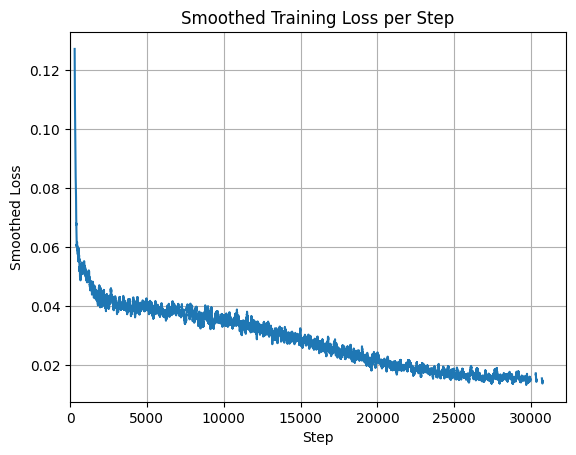

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

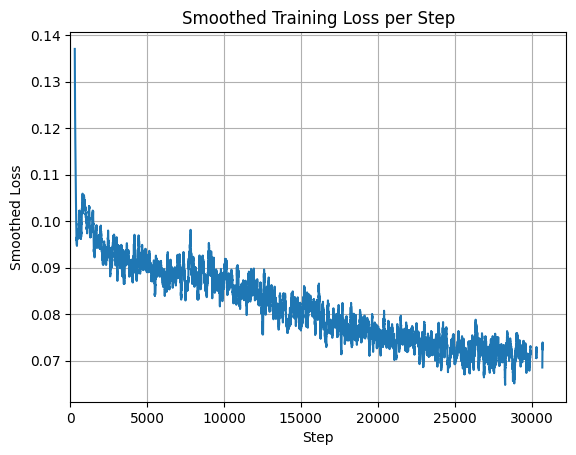

___________________________________________________________________________________________________________________________


In [79]:
device_name = '/device:GPU:0'
#dqn_eval2(thing=True,flag=False)
# print(np.mean(scores.history['episode_reward'])*100,'%')
# plt.plot(scores.history['episode_reward'])
# plt.title('Testing Rewards per Episode')
# plt.xlabel('Episode')
# plt.ylabel('Cumulative Reward')
# plt.show()
# print(np.mean(scores.history['episode_reward'])*100,'%')
dqn.policy.eps = 0
# train_new = np.load(file='/content/drive/MyDrive/a/bciiv2a_test_features_A02E.gdf.npy')
# train_new_labels = train_dict['A02T.gdf']['labels']

#dqn_eval(dqn,d=(X_test[len(X_test)-25:],y_test[len(y_test)-25:]))
dqn_eval(dqn,d=(X_test,y_test))

dqn.policy.eps = 0.5
scores = dqn.test(Plasticity(images_per_episode=1,random=True,dataset=(X_test,y_test)), nb_episodes=100, visualize=False, action_repetition=1, verbose=1)
print(np.mean(scores.history['episode_reward'])*100.,'%')


def moving_average(data, window_size):
    return [np.mean(data[i:i+window_size]) for i in range(len(data) - window_size + 1)]
losses = loss_history.losses
losses2 = loss_history2.losses
smoothed_losses = moving_average(losses, window_size=50)
print(smoothed_losses)
plt.plot(smoothed_losses)
plt.title('Smoothed Training Loss per Step')
plt.xlabel('Step')
plt.xlim(left=0)
plt.ylabel('Smoothed Loss')
plt.grid(True)
plt.show()

smoothed_losses2 = moving_average(losses2, window_size=70)
print(smoothed_losses2)
plt.plot(smoothed_losses2)
plt.title('Smoothed Training Loss per Step')
plt.xlabel('Step')
plt.xlim(left=0)
plt.ylabel('Smoothed Loss')
plt.grid(True)
plt.show()

# plt.plot(moving_average(reward_history.rewards, window_size=70))
# plt.title('Training Rewards per Episode')
# plt.xlabel('Episode')
# plt.ylabel('Cumulative Reward')
# plt.show()

print("___________________________________________________________________________________________________________________________")

In [80]:
def clear_memory(memory):
    """
    Reinitializes the given SequentialMemory instance to clear its contents.

    Args:
    memory (SequentialMemory): The memory instance to clear.

    Returns:
    SequentialMemory: A new, empty memory instance with the same settings as the original.
    """
    new_memory = SequentialMemory(limit=memory.limit, window_length=memory.window_length)
    return new_memory

# Usage
# Assuming `memory` is your instance of SequentialMemory
#memory = clear_memory(memory)

class ExtendedSequentialMemory(SequentialMemory):
    def get_experience(self, index):
        """Retrieve a single experience by index."""
        if index < 0 or index >= self.nb_entries:
            raise ValueError("Index out of bounds")

        # Access internal ring buffers directly
        state = self.observations[index]
        action = self.actions[index]
        reward = self.rewards[index]
        terminal = self.terminals[index]

        return state, action, reward, terminal



In [81]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, LSTM
from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from sklearn.model_selection import train_test_split
experience_replay_memory = []
#with tf.device('/device:GPU:0'):
model2 = build_model(states, actions)
model2.build(input_shape=(1,GLOBAL_SHAPE_LENGTH))
model2.load_weights(prefix+'test4_myweights_goodmodel.hdf5')
model2.summary()

def continuous_learning(subject_train_data, subject_test_data, subject_train_labels, subject_test_labels, thedqn, train_flag=True, epsilon=1.0):
    big_dataset = np.empty((0,GLOBAL_SHAPE_LENGTH))
    big_labels_dataset = np.empty((0,))
    for subject_id in subject_train_data:
      epsilon_decay_cb = ExponentialDecayEpsilonCallback(initial_epsilon, min_epsilon, 0.00001, 1000000)
      #thedqn.memory = individual_mem[subject_id-1]
      nb_steps=1000
      print(f'=========== SUBJECT ID: {subject_id} ===========')

      X_train2 = subject_train_data[subject_id]
      y_train2 = subject_train_labels[subject_id]
      X_test2 = subject_test_data[subject_id]
      y_test2 = subject_test_labels[subject_id]
      big_dataset = np.concatenate((big_dataset,X_train2))
      big_labels_dataset = np.concatenate((big_labels_dataset,y_train2))
      print(big_dataset.shape,big_labels_dataset.shape)
      #thedqn.memory = individual_mem[subject_id-1]
      print('xtrain',X_train2.shape,'xtest',X_test2.shape,'ytrain',y_train2.shape,'ytest',y_test2.shape)

      train_env2 = Plasticity(dataset=(X_train2,y_train2))

      #thedqn.policy.eps = epsilon
      if(train_flag):

        
        if(subject_id >= 7):
          history = thedqn.fit(train_env2, nb_steps=nb_steps, callbacks = [epsilon_decay_cb], visualize=False, verbose=1)
          rewards = history.history['episode_reward']
          while np.mean(rewards) < 0.75:
            
            history = thedqn.fit(train_env2, nb_steps=nb_steps, callbacks = [epsilon_decay_cb], visualize=False, verbose=1)
            rewards = history.history['episode_reward']

            print(f"Average reward: {np.mean(rewards)}. Continuing training.")
            nb_steps += 500
          #end while
          batch_size = int(thedqn.memory.nb_entries * 0.5)
        
          print('Number of entries in general memory:', thedqn.memory.nb_entries)

          sampled_experiences = thedqn.memory.sample(batch_size)


          thedqn.memory = clear_memory(thedqn.memory)
          for experience in sampled_experiences:
            thedqn.memory.append(
              observation=experience.state0,
              action=experience.action,
              reward=experience.reward,
              terminal=experience.terminal1
            )
          print('Number of entries in general memory after pruning:', thedqn.memory.nb_entries)
        #endif
      #endif
        
      # thedqn.policy.eps = 0.005
      # thedqn.fit(Plasticity(dataset=(big_dataset, big_labels_dataset)), nb_steps=5000, visualize=False, verbose=1)
      
      thedqn.policy.eps = 0.0001
      thedqn.fit(Plasticity(dataset=(big_dataset, big_labels_dataset)), nb_steps=10000, visualize=False, verbose=1)
      for id in range(1,10):
        print("ALL SUBJECTS VALIDATION: ",id)
        X_test3 = subject_test_data[id]
        y_test3 = subject_test_labels[id]
        dqn_eval(dqn2,d=(X_test3,y_test3))
      thedqn.save_weights(prefix+"bciiv2a_dqn_weights2.hdf5",overwrite=True)

subject_train_data = {}
subject_test_data = {}
subject_train_labels = {}
subject_test_labels = {}
k = 1
subject_train_data[k] = np.load(prefix+f"bciiv2a_train_features_A0{k}T.gdf.npy")
subject_test_data[k]  = np.load(prefix+f"bciiv2a_test_features_A0{k}E.gdf.npy")
subject_train_labels[k] = train_dict[f'A0{k}T.gdf']['labels']
subject_test_labels[k]  = test_dict[f'A0{k}E.gdf']['labels']

for i in range(2,10):
  subject_train_data[i] = np.load(prefix+f"bciiv2a_train_features_A0{i}T.gdf.npy")
  subject_test_data[i]  = np.load(prefix+f"bciiv2a_test_features_A0{i}E.gdf.npy")
  subject_train_labels[i] = train_dict[f'A0{i}T.gdf']['labels']
  subject_test_labels[i]  = test_dict[f'A0{i}E.gdf']['labels']

for subject_id in subject_train_data:
    #print(subject_id)
    X_train = subject_train_data[subject_id]
    y_train = subject_train_labels[subject_id]
    X_test = subject_test_data[subject_id]
    y_test = subject_test_labels[subject_id]
    #print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
    indices_to_remove_train = np.where(y_train == 3)[0]
    indices_to_remove_test = np.where(y_test == 3)[0]

    X_train = np.delete(X_train, indices_to_remove_train, axis=0)
    y_train = np.delete(y_train, indices_to_remove_train, axis=0)
    X_test = np.delete(X_test, indices_to_remove_test, axis=0)
    y_test = np.delete(y_test, indices_to_remove_test, axis=0)

    scaler = StandardScaler()
    smote = SMOTE(sampling_strategy='all', k_neighbors=50, random_state=42)

    X_syn,y_syn = smote.fit_resample(X_test,y_test)

    X_train = np.concatenate((X_train,X_syn))
    y_train = np.concatenate((y_train,y_syn))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    #print(X_train.shape, X_test.shape,y_train.shape,y_test.shape)
    scaler2 = MinMaxScaler((0,1))
    X_train = scaler2.fit_transform(X_train)
    X_test = scaler2.transform(X_test)

    subject_train_data[subject_id] = X_train
    subject_train_labels[subject_id]  = y_train
    subject_test_data[subject_id] = X_test
    subject_test_labels[subject_id]  = y_test
#print(type(subject_id))
# with tf.device('/device:CPU:0'):
#   dqn2 = build_agent(model2, actions)
#   dqn2.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005,decay=1e-5),metrics=['mse'])
#   dqn2.load_weights(prefix+'bciiv2a_dqn_weights2.hdf5')
#   continuous_learning(subject_train_data, subject_test_data, subject_train_labels, subject_test_labels, dqn2, train_flag=True, epsilon=1.0)

NameError: name 'prefix' is not defined

In [ ]:
# #continuous_learning(subject_train_data, subject_test_data, subject_train_labels, subject_test_labels, dqn2, train_flag=False, epsilon=0)

# # dqn3 = build_agent(model2, actions)
# # dqn3.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0055,decay=1e-3),metrics=['mse'])
# # dqn3.load_weights(prefix+'bciiv2a_dqn_weights2.hdf5')
# dqn2.load_weights(prefix+'bciiv2a_dqn_weights2.hdf5')
# for subject_id in range(1,10):
  
#   X_train3 = subject_train_data[subject_id]
#   y_train3 = subject_train_labels[subject_id]
#   X_test3 = subject_test_data[subject_id]
#   y_test3 = subject_test_labels[subject_id]
#   print("TESTING ON TRAIN FOLDS: SUBJECT ",subject_id)
#   dqn_eval3(dqn2,(X_train3,y_train3))
#   print("TESTING ON TEST FOLDS: SUBJECT ",subject_id)
#   dqn_eval3(dqn2,(X_test3,y_test3))

# big_tr = np.empty((0,GLOBAL_SHAPE_LENGTH))
# big_tr_lab = np.empty((0,))
# big_te = np.empty((0,GLOBAL_SHAPE_LENGTH))
# big_te_lab = np.empty((0,))

# for subject_id in range(1,10):
  
#   X_train3 = subject_train_data[subject_id]
#   y_train3 = subject_train_labels[subject_id]
#   X_test3 = subject_test_data[subject_id]
#   y_test3 = subject_test_labels[subject_id]
#   big_tr = np.concatenate((big_tr,X_train3))
#   big_tr_lab = np.concatenate((big_tr_lab,y_train3))
#   big_te = np.concatenate((big_te,X_test3))
#   big_te_lab = np.concatenate((big_te_lab,y_test3))

# dqn_eval3(dqn2,(big_tr, big_tr_lab))
# dqn_eval3(dqn2,(big_te, big_te_lab))
# big_tr = np.concatenate((big_tr,big_te))
# big_tr_lab = np.concatenate((big_tr_lab,big_te_lab))
# dqn_eval3(dqn2,(big_tr, big_tr_lab))


In [ ]:
for i in range(1,10):
    model3 = build_model(states, actions)
    model3.build(input_shape=(1,GLOBAL_SHAPE_LENGTH))
    model3.load_weights(prefix+'test4_myweights_goodmodel.hdf5')
    initial_epsilon = 1.0 
    min_epsilon = 0.0 
    decay_rate = 0.001  
    decay_steps = 14000/(decay_rate*50.0)

    epsilon_decay_cb = ExponentialDecayEpsilonCallback(initial_epsilon, min_epsilon, decay_rate, decay_steps)
    dqn3 = build_agent(model3, actions)
    dqn3.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0055,decay=1e-3),metrics=['mse'])

    dqn3.fit(Plasticity(dataset=(subject_train_data[i],subject_train_labels[i])), nb_steps=5000, callbacks=[loss_history,loss_history2,reward_history,epsilon_decay_cb], verbose=1)
    dqn_eval3(dqn3,(subject_test_data[i],subject_test_labels[i]))

NameError: name 'prefix' is not defined